# Problem Statement
In this assignment, you would face real world data of applications and bureau as shared by Home Credit, to perform the end-to-end process of model development in Credit Risk for Banks, Financial Institutions and NBFCs.

Build a bank’s internal end-to-end scoring mechanism, based on the application information, clubbed with the raw bureau information.

The primary objective of this study is to assist Home Credit in deciding which loan applications should be disbursed, and which should be rejected, based on the applicant’s past behaviour and application information.

## Goal:

As a business analyst for Home Credit, you are supposed to first gather the information and clean it to make it usable.

The bureau information is at trade level, each individual trade level information is provided. You need to apply ‘Feature Engineering’ techniques to roll up the information at applicant level, and thereby create manual features for model building.

Build a classification model to differentiate applicants between approves and rejects.

### As a business analyst, you would want to find answers to the below questions for the bank:

How to leverage trade level information for Credit Bureaus by aggregating trade level information to applicant level in order to capture their payment behaviour?
Which application or payment behaviour factors significantly influence borrower’s behaviour on any new disbursed loan?
After identifying these factors, how to leverage them in the form of a model which can be used for decisioning?
Once the model is built, how to translate the model output into strategies and business insights for the bank?


**Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import pickle

In [3]:
# Set random seed for reproducibility
np.random.seed(42)


## Data Understanding
**To perform the credit risk analysis we have two datasets**

**Application_base** **&**
**Bureau**

# Load the application dataset

In [4]:

print("Loading application data...")
df_app = pd.read_csv('applications_base.csv')  
print("Application Shape:", df_app.shape)
print("\nApplication Head:\n", df_app.head())

Loading application data...
Application Shape: (307511, 122)

Application Head:
    SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUM

In [5]:
df_app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


**SK_ID_CURR is the unique identifier for the applications table. Applications table consists of each individual loan applicant consisting of 122 features.**

TARGET is the dependent variable for our classification problem

1 - Defaulter (Bad Customer) - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample,
0 - Not Defaulter(Good Customer)

In [6]:
# After loading df_app and before EDA
num_cols = df_app.select_dtypes(include=['int64', 'float64']).columns.drop('SK_ID_CURR')
cat_cols = df_app.select_dtypes(include=['object']).columns

## Target variable distribution for Application Dataset

In [7]:

print("Target Distribution (Absolute Counts):")
print(df_app.TARGET.value_counts())
print("\nTarget Distribution (Proportions):")
print(df_app.TARGET.value_counts(normalize=True) * 100)

Target Distribution (Absolute Counts):
TARGET
0    282686
1     24825
Name: count, dtype: int64

Target Distribution (Proportions):
TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


**Based on the target variable we identified that**

0 implies that 92% of customers are Not defaulters
1 implies that 8 % of customers are defaulters

# Load the bureau dataset

In [8]:

print("Loading bureau data...")
df_bureau = pd.read_csv('bureau.csv')  
print("Bureau Shape:", df_bureau.shape)
print("\nBureau Head:\n", df_bureau.head())

Loading bureau data...
Bureau Shape: (1716428, 17)

Bureau Head:
    SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN        

# Checking Duplicates

In [9]:
print(f"Duplicate SK_ID_CURR in df_app: {df_app['SK_ID_CURR'].duplicated().sum()}")
print(f"Duplicate SK_ID_CURR in df_bureau: {df_bureau['SK_ID_CURR'].duplicated().sum()}")

Duplicate SK_ID_CURR in df_app: 0
Duplicate SK_ID_CURR in df_bureau: 1410617


# Data Cleaning , Handle Missing Values & Handle Outliers


## Identify and Replace missing values in Application Dataset

In [10]:

missing_values = {}
for col in df_app.columns:
    missing_count = round(df_app[col].isna().mean() * 100, 2)
    if missing_count > 0:
        missing_values[col] = missing_count
missing_df = pd.DataFrame(list(missing_values.items()), columns=['Column', 'Missing_Percentage'])
print("\nMissing Values in Application Data:\n", missing_df)


Missing Values in Application Data:
                         Column  Missing_Percentage
0              AMT_GOODS_PRICE                0.09
1              NAME_TYPE_SUITE                0.42
2                  OWN_CAR_AGE               65.99
3              OCCUPATION_TYPE               31.35
4                 EXT_SOURCE_1               56.38
..                         ...                 ...
59   AMT_REQ_CREDIT_BUREAU_DAY               13.50
60  AMT_REQ_CREDIT_BUREAU_WEEK               13.50
61   AMT_REQ_CREDIT_BUREAU_MON               13.50
62   AMT_REQ_CREDIT_BUREAU_QRT               13.50
63  AMT_REQ_CREDIT_BUREAU_YEAR               13.50

[64 rows x 2 columns]


# Impute missing values

In [11]:
from sklearn.impute import SimpleImputer
numeric_imputer = SimpleImputer(strategy='median')
df_app[num_cols] = numeric_imputer.fit_transform(df_app[num_cols])
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
df_app[cat_cols] = cat_imputer.fit_transform(df_app[cat_cols])

# Remove columns with >40% missing values

In [12]:
cols_to_remove = ['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 
                  'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 
                  'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 
                  'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 
                  'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 
                  'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
                  'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 
                  'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 
                  'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 
                  'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

In [13]:
df_app = df_app.drop(cols_to_remove, axis=1)
print("\nShape after removing columns with >40% missing values:", df_app.shape)
print("\nRemaining Missing Values in Application Data (%):\n", round(df_app.isnull().mean() * 100, 2))


Shape after removing columns with >40% missing values: (307511, 73)

Remaining Missing Values in Application Data (%):
 SK_ID_CURR                    0.0
TARGET                        0.0
NAME_CONTRACT_TYPE            0.0
CODE_GENDER                   0.0
FLAG_OWN_CAR                  0.0
                             ... 
AMT_REQ_CREDIT_BUREAU_DAY     0.0
AMT_REQ_CREDIT_BUREAU_WEEK    0.0
AMT_REQ_CREDIT_BUREAU_MON     0.0
AMT_REQ_CREDIT_BUREAU_QRT     0.0
AMT_REQ_CREDIT_BUREAU_YEAR    0.0
Length: 73, dtype: float64


In [14]:
df_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  float64
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  float64
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307511 non-null  float64
 10  AMT_GOODS_PRICE              307511 non-null  float64
 11  NAME_TYPE_SUITE              307511 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

In [15]:
print("\nBureau Data Info:")
print(df_bureau.info())
print("\nBureau Missing Values (%):\n", df_bureau.isnull().mean() * 100)
print("\nBureau Descriptive Statistics:\n", df_bureau.describe())


Bureau Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
None

Bureau Missing Values (%):
 SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.00

In [16]:
round(df_app.isnull().mean()*100,2)

SK_ID_CURR                    0.0
TARGET                        0.0
NAME_CONTRACT_TYPE            0.0
CODE_GENDER                   0.0
FLAG_OWN_CAR                  0.0
                             ... 
AMT_REQ_CREDIT_BUREAU_DAY     0.0
AMT_REQ_CREDIT_BUREAU_WEEK    0.0
AMT_REQ_CREDIT_BUREAU_MON     0.0
AMT_REQ_CREDIT_BUREAU_QRT     0.0
AMT_REQ_CREDIT_BUREAU_YEAR    0.0
Length: 73, dtype: float64

# Update num_cols after dropping columns

In [17]:
num_cols = df_app.select_dtypes(include=['int64', 'float64']).columns.drop('SK_ID_CURR')
cat_cols = df_app.select_dtypes(include=['object']).columns

# Visualize boxplots to identify outliers

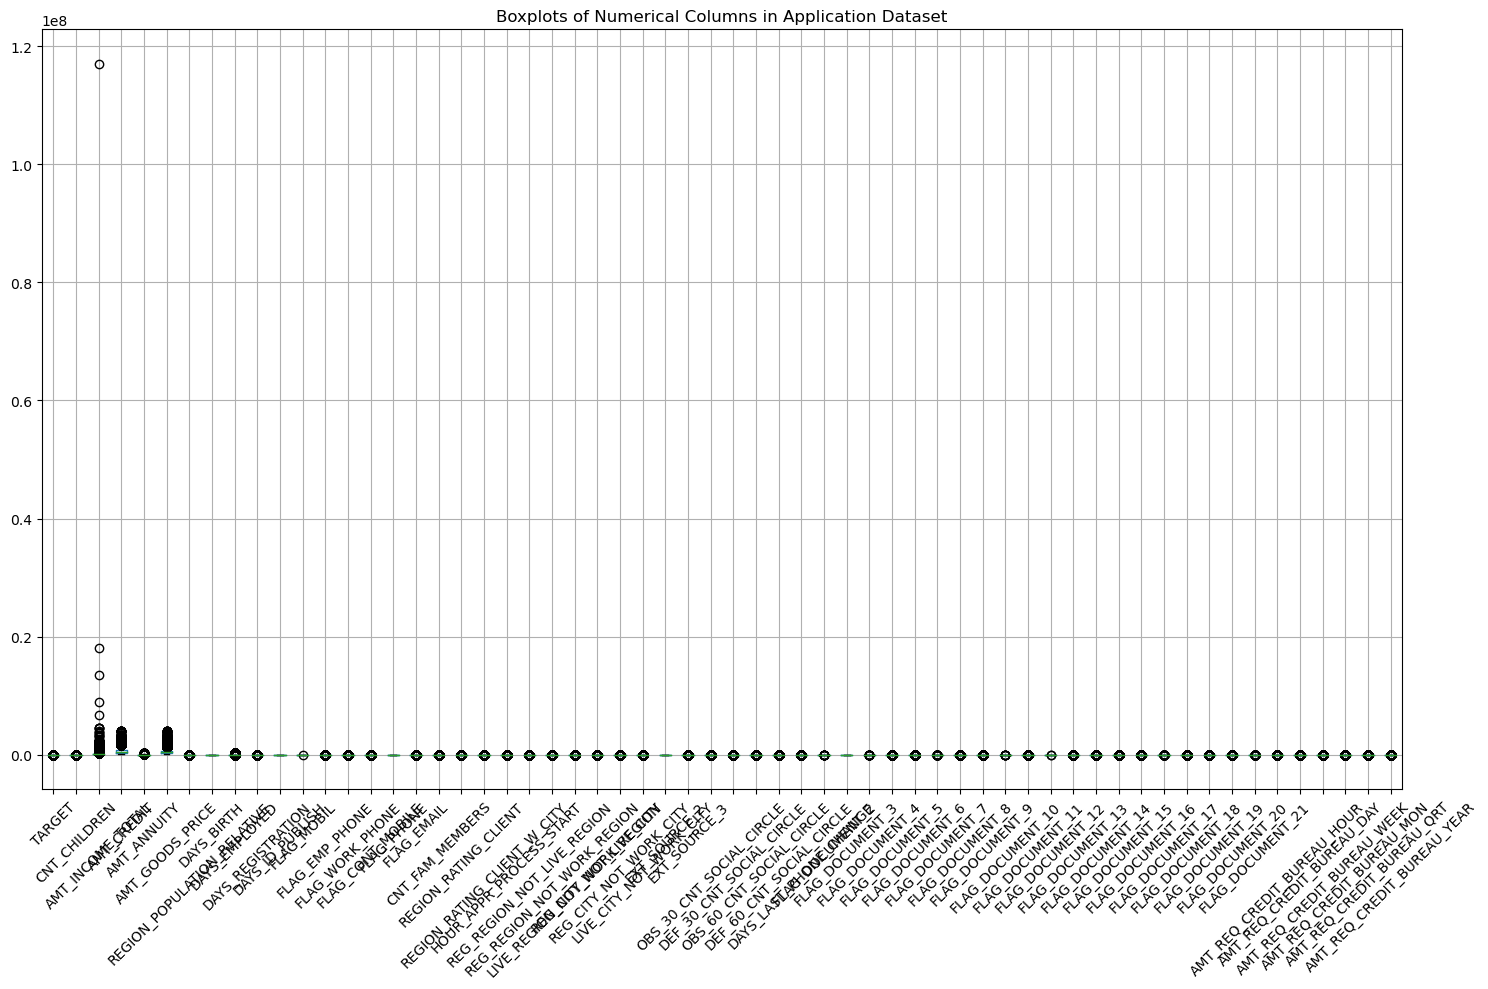

In [18]:
plt.figure(figsize=(15, 10))
df_app[num_cols].boxplot()
plt.title("Boxplots of Numerical Columns in Application Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate IQR to quantify outliers

In [19]:
Q1 = df_app[num_cols].quantile(0.25)
Q3 = df_app[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df_app[num_cols] < (Q1 - 1.5 * IQR)) | (df_app[num_cols] > (Q3 + 1.5 * IQR))).sum()
print("\nNumber of Outliers per Numerical Column (IQR Method):\n", outliers)


Number of Outliers per Numerical Column (IQR Method):
 TARGET                         24825
CNT_CHILDREN                    4272
AMT_INCOME_TOTAL               14035
AMT_CREDIT                      6562
AMT_ANNUITY                     7504
AMT_GOODS_PRICE                14728
REGION_POPULATION_RELATIVE      8412
DAYS_BIRTH                         0
DAYS_EMPLOYED                  72217
DAYS_REGISTRATION                659
DAYS_ID_PUBLISH                    0
FLAG_MOBIL                         1
FLAG_EMP_PHONE                 55386
FLAG_WORK_PHONE                61308
FLAG_CONT_MOBILE                 574
FLAG_PHONE                         0
FLAG_EMAIL                     17442
CNT_FAM_MEMBERS                 4007
REGION_RATING_CLIENT           80527
REGION_RATING_CLIENT_W_CITY    78027
HOUR_APPR_PROCESS_START         2257
REG_REGION_NOT_LIVE_REGION      4657
REG_REGION_NOT_WORK_REGION     15612
LIVE_REGION_NOT_WORK_REGION    12503
REG_CITY_NOT_LIVE_CITY         24039
REG_CITY_NOT_WORK_C

# Cap outliers at 95th percentile for numerical columns

In [20]:
print("\nNumerical columns for outlier capping:", num_cols.tolist())
for col in num_cols:
    upper_limit = df_app[col].quantile(0.95)
    df_app[col] = df_app[col].clip(upper=upper_limit)


Numerical columns for outlier capping: ['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUME

# Apply log transformation for skewed financial variables (e.g., AMT_INCOME_TOTAL, AMT_CREDIT)

In [21]:

skewed_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']  # Add other skewed cols from EDA
for col in skewed_cols:
    if col in num_cols:
        df_app[col] = np.log1p(df_app[col])  # log1p handles zero values

# Verify changes with updated boxplots

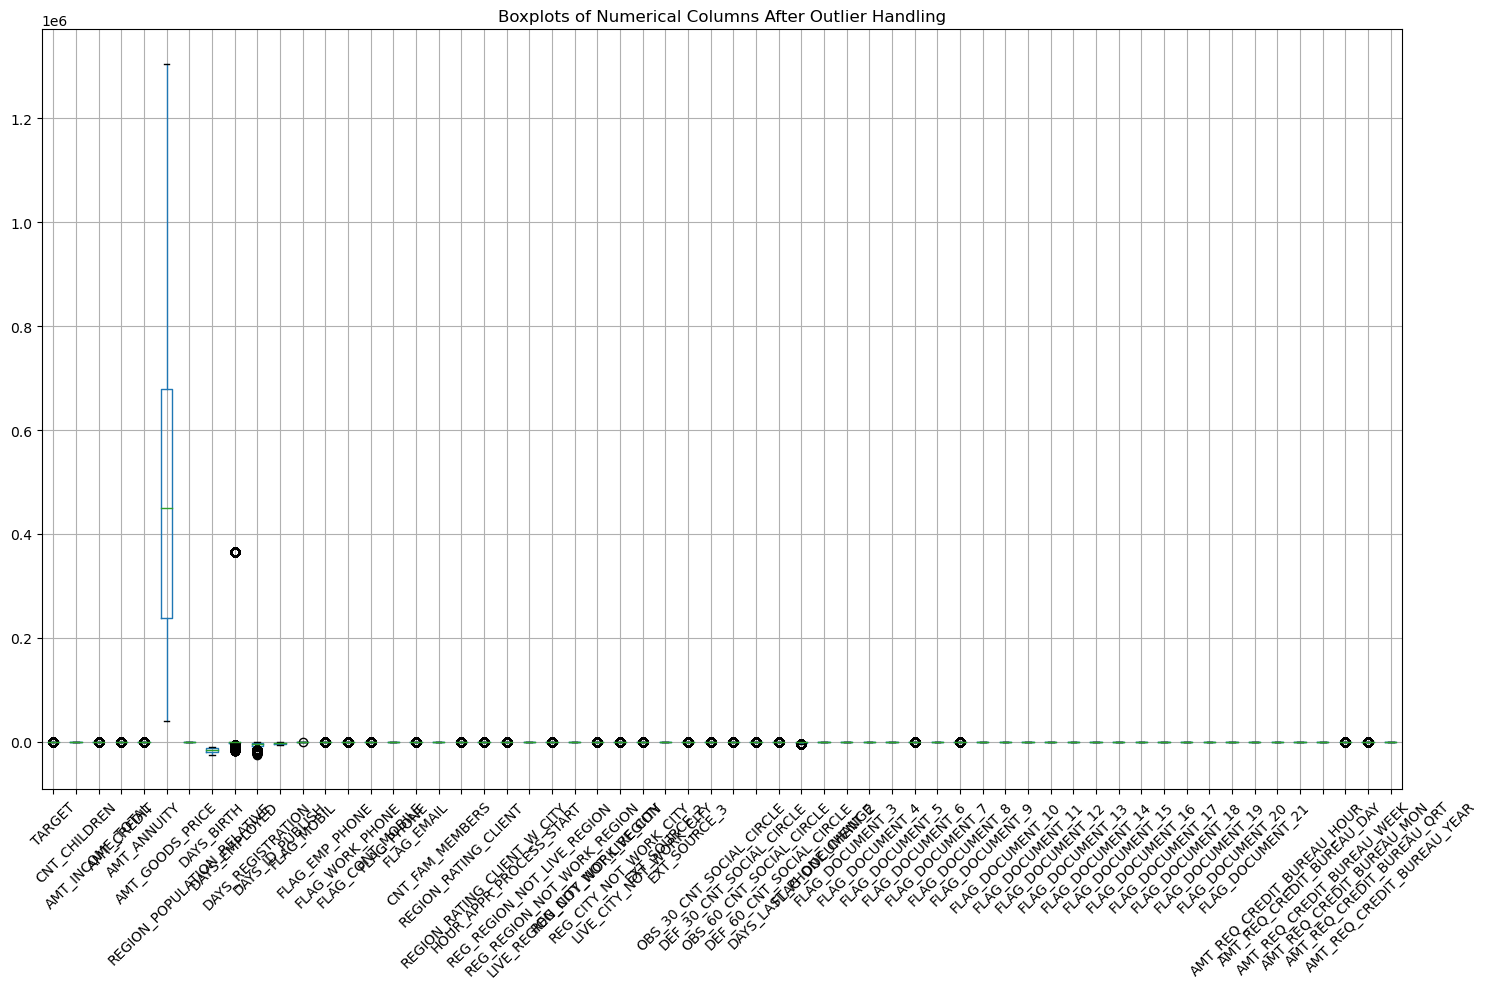


Summary Statistics After Outlier Handling:
               TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL     AMT_CREDIT  \
count  307511.000000  307511.000000     307511.000000  307511.000000   
mean        0.080729       0.400509         11.897057      13.060180   
std         0.272419       0.664724          0.460570       0.698135   
min         0.000000       0.000000         10.152338      10.714440   
25%         0.000000       0.000000         11.630717      12.506181   
50%         0.000000       0.000000         11.899215      13.149068   
75%         0.000000       1.000000         12.218500      13.603123   
max         1.000000       2.000000         12.729324      14.115616   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  307511.000000     3.075110e+05               307511.000000   
mean       10.058591     5.260981e+05                    0.020149   
std         0.528852     3.328345e+05                    0.011637   
min         7.388019     4.050

In [22]:

plt.figure(figsize=(15, 10))
df_app[num_cols].boxplot()
plt.title("Boxplots of Numerical Columns After Outlier Handling")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics to confirm
print("\nSummary Statistics After Outlier Handling:\n", df_app[num_cols].describe())

# Check missing values after removal

In [23]:

print("\nRemaining Missing Values in Application Data (%):\n", round(df_app.isnull().mean() * 100, 2))


Remaining Missing Values in Application Data (%):
 SK_ID_CURR                    0.0
TARGET                        0.0
NAME_CONTRACT_TYPE            0.0
CODE_GENDER                   0.0
FLAG_OWN_CAR                  0.0
                             ... 
AMT_REQ_CREDIT_BUREAU_DAY     0.0
AMT_REQ_CREDIT_BUREAU_WEEK    0.0
AMT_REQ_CREDIT_BUREAU_MON     0.0
AMT_REQ_CREDIT_BUREAU_QRT     0.0
AMT_REQ_CREDIT_BUREAU_YEAR    0.0
Length: 73, dtype: float64


### Convert numerical columns to float

In [24]:

for i in num_cols:
    df_app[i] = df_app[i].astype('float')

# Identify and Replace missing values in Bureau Dataset

In [25]:
df_bureau.shape

(1716428, 17)

In [26]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [27]:
df_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [28]:
df_bureau.isnull().mean()*100

SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.000000
CREDIT_ACTIVE              0.000000
CREDIT_CURRENCY            0.000000
DAYS_CREDIT                0.000000
CREDIT_DAY_OVERDUE         0.000000
DAYS_CREDIT_ENDDATE        6.149573
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_MAX_OVERDUE    65.513264
CNT_CREDIT_PROLONG         0.000000
AMT_CREDIT_SUM             0.000757
AMT_CREDIT_SUM_DEBT       15.011932
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_OVERDUE     0.000000
CREDIT_TYPE                0.000000
DAYS_CREDIT_UPDATE         0.000000
AMT_ANNUITY               71.473490
dtype: float64

In [29]:
df_bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [30]:

print("\nBureau Data Info:")
print(df_bureau.info())
print("\nBureau Missing Values (%):\n", df_bureau.isnull().mean() * 100)


Bureau Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
None

Bureau Missing Values (%):
 SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.00

# Identify and handle missing values in Bureau Dataset

In [31]:
bureau_missing = df_bureau.isnull().mean() * 100
print("\nBureau Missing Values (%):\n", bureau_missing)
cols_to_drop_bureau = bureau_missing[bureau_missing > 40].index
if not cols_to_drop_bureau.empty:
    print(f"\nDropping columns with >40% missing values: {cols_to_drop_bureau.tolist()}")
    df_bureau = df_bureau.drop(cols_to_drop_bureau, axis=1)
    print("New Bureau Shape after dropping columns:", df_bureau.shape)
else:
    print("\nNo columns with >40% missing values to drop.")


Bureau Missing Values (%):
 SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.000000
CREDIT_ACTIVE              0.000000
CREDIT_CURRENCY            0.000000
DAYS_CREDIT                0.000000
CREDIT_DAY_OVERDUE         0.000000
DAYS_CREDIT_ENDDATE        6.149573
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_MAX_OVERDUE    65.513264
CNT_CREDIT_PROLONG         0.000000
AMT_CREDIT_SUM             0.000757
AMT_CREDIT_SUM_DEBT       15.011932
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_OVERDUE     0.000000
CREDIT_TYPE                0.000000
DAYS_CREDIT_UPDATE         0.000000
AMT_ANNUITY               71.473490
dtype: float64

Dropping columns with >40% missing values: ['AMT_CREDIT_MAX_OVERDUE', 'AMT_ANNUITY']
New Bureau Shape after dropping columns: (1716428, 15)


## Segment categorical and numerical variables in df_bureau

In [32]:
cat_cols_bureau = df_bureau.select_dtypes(include=['object']).columns
num_cols_bureau = df_bureau.select_dtypes(include=['int64', 'float64']).columns.drop(['SK_ID_CURR', 'SK_ID_BUREAU'])
print("\nCategorical Columns in Bureau Data:", cat_cols_bureau.tolist())
print("Numerical Columns in Bureau Data:", num_cols_bureau.tolist())


Categorical Columns in Bureau Data: ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
Numerical Columns in Bureau Data: ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE']


# Impute missing values

In [33]:
from sklearn.impute import SimpleImputer
numeric_imputer = SimpleImputer(strategy='median')
df_bureau[num_cols_bureau] = numeric_imputer.fit_transform(df_bureau[num_cols_bureau])
cat_imputer = SimpleImputer(strategy='most_frequent')
df_bureau[cat_cols_bureau] = cat_imputer.fit_transform(df_bureau[cat_cols_bureau])
print("\nRemaining Missing Values in Bureau Data (%):\n", df_bureau.isnull().mean() * 100)


Remaining Missing Values in Bureau Data (%):
 SK_ID_CURR                0.0
SK_ID_BUREAU              0.0
CREDIT_ACTIVE             0.0
CREDIT_CURRENCY           0.0
DAYS_CREDIT               0.0
CREDIT_DAY_OVERDUE        0.0
DAYS_CREDIT_ENDDATE       0.0
DAYS_ENDDATE_FACT         0.0
CNT_CREDIT_PROLONG        0.0
AMT_CREDIT_SUM            0.0
AMT_CREDIT_SUM_DEBT       0.0
AMT_CREDIT_SUM_LIMIT      0.0
AMT_CREDIT_SUM_OVERDUE    0.0
CREDIT_TYPE               0.0
DAYS_CREDIT_UPDATE        0.0
dtype: float64


In [34]:
# Handle outliers

In [35]:
for col in num_cols_bureau:
    upper_limit = df_bureau[col].quantile(0.95)
    df_bureau[col] = df_bureau[col].clip(upper=upper_limit)

# --- Step 2: Exploratory Data Analysis (EDA)

## Application Dataset EDA

# Boxplots for numerical variables

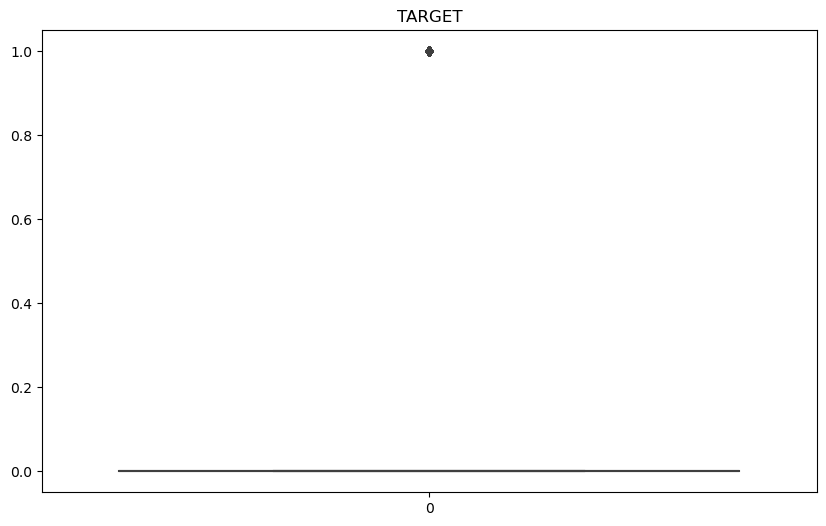

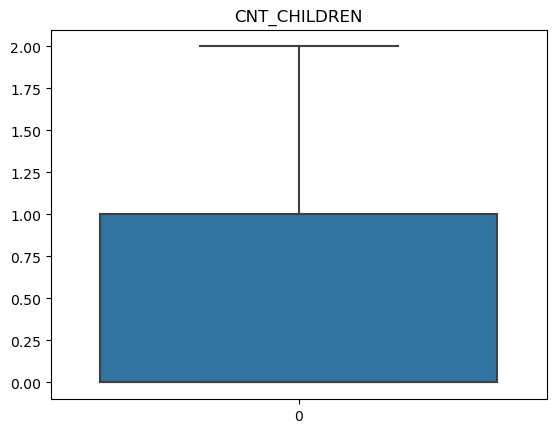

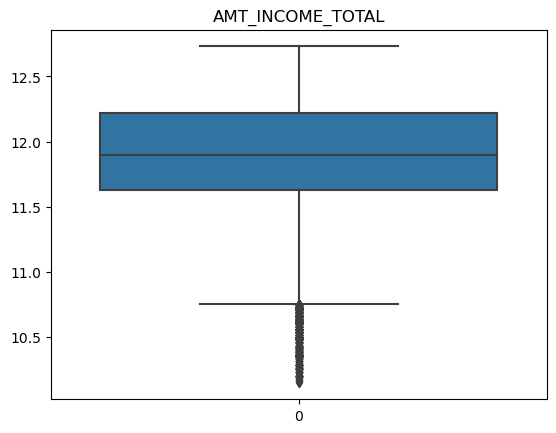

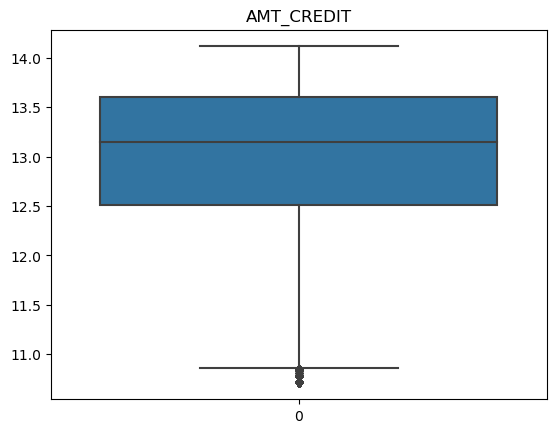

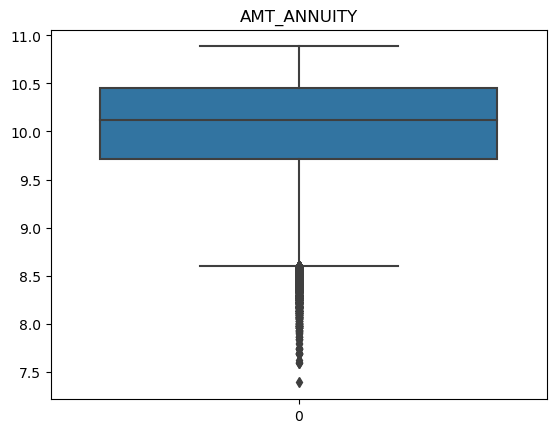

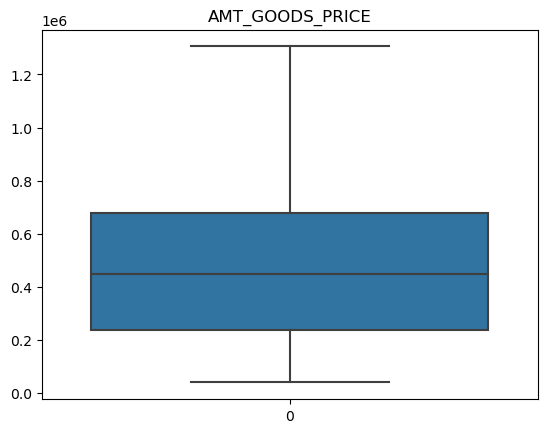

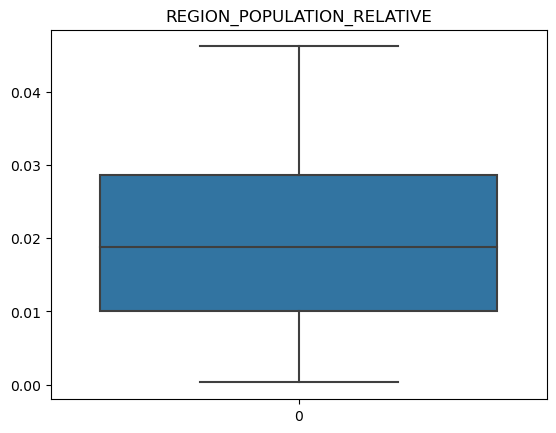

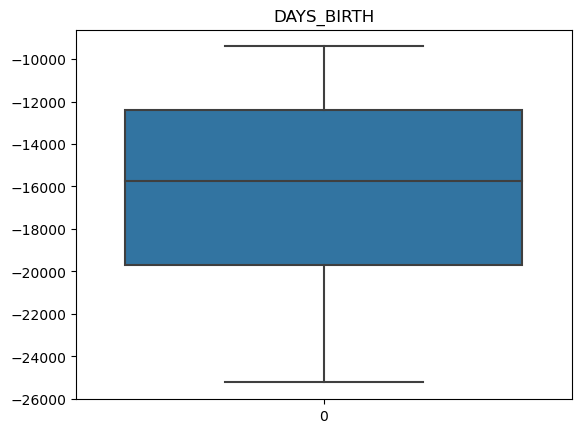

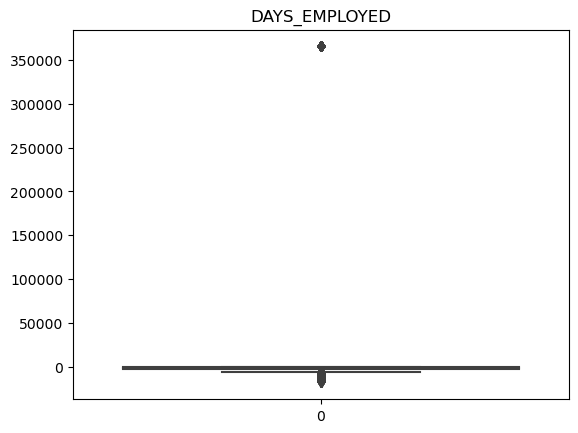

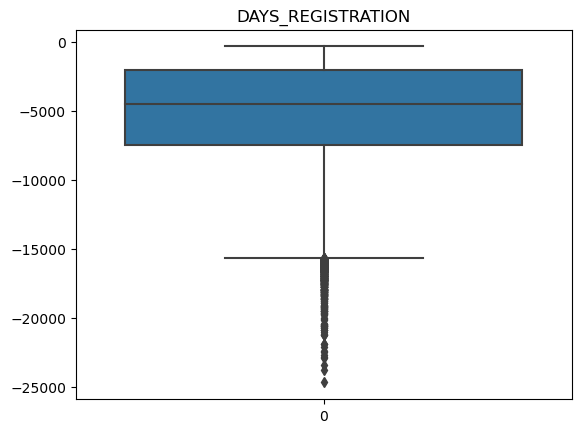

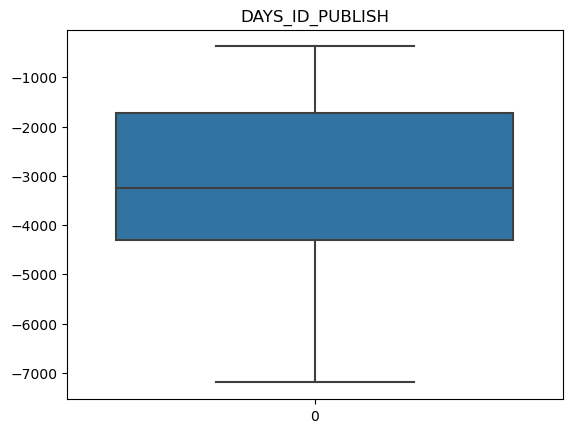

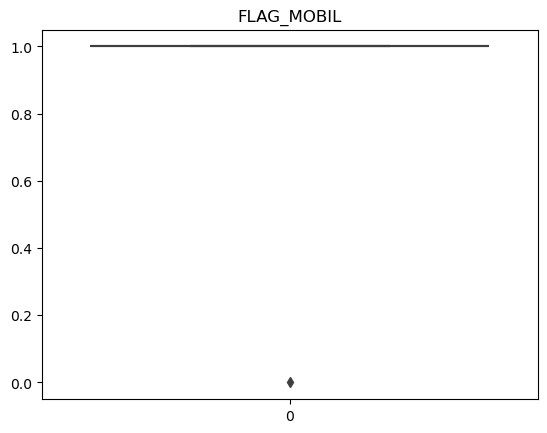

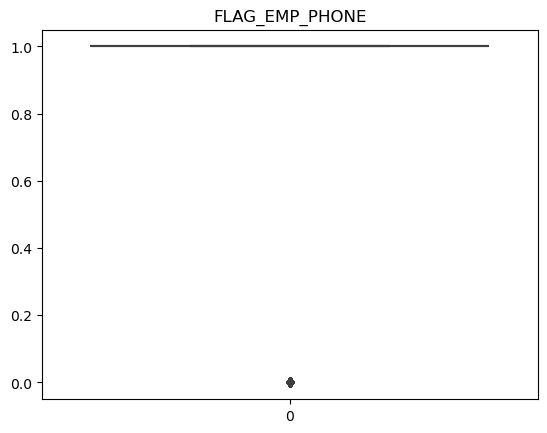

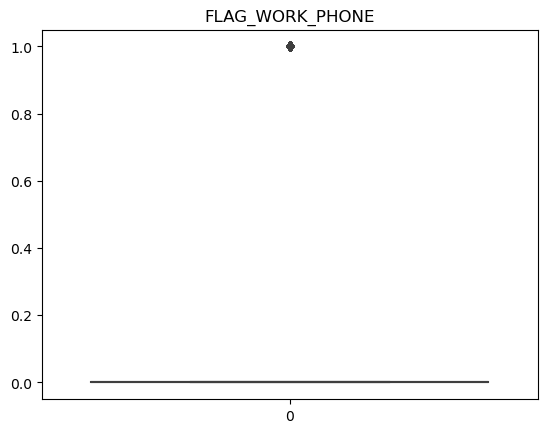

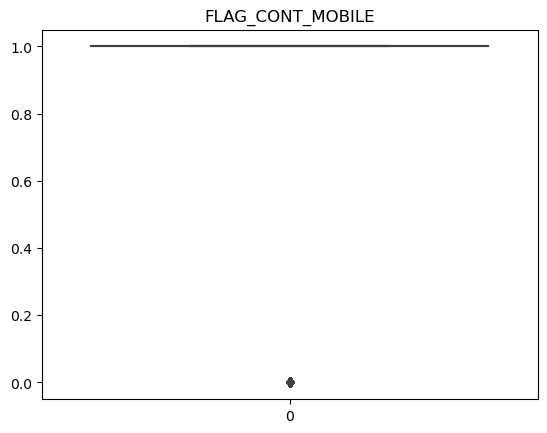

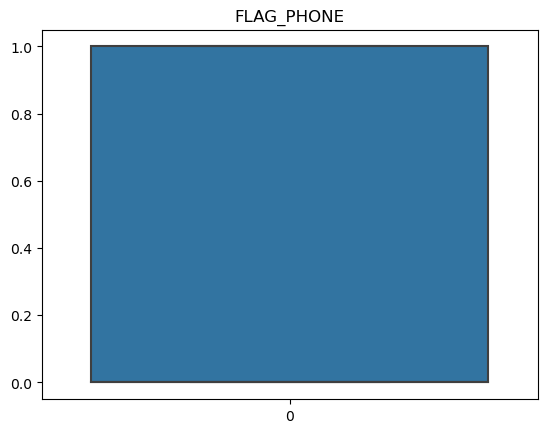

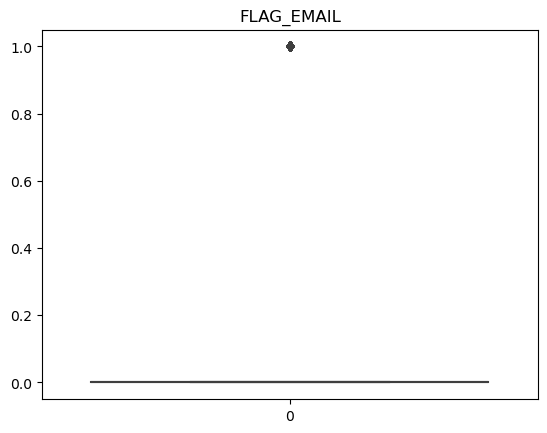

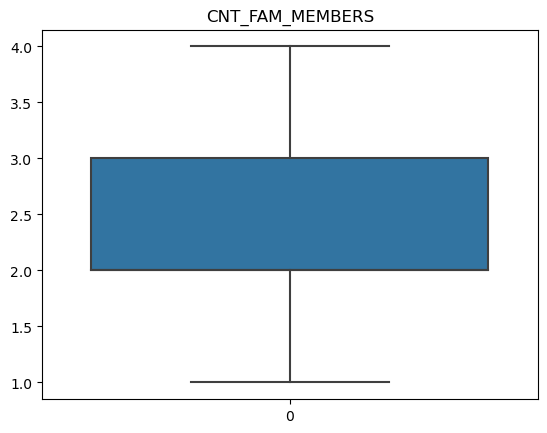

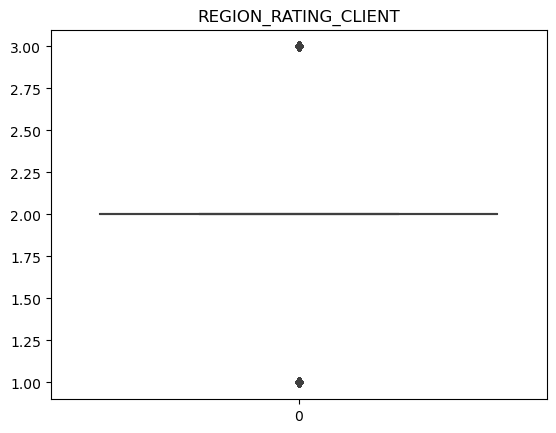

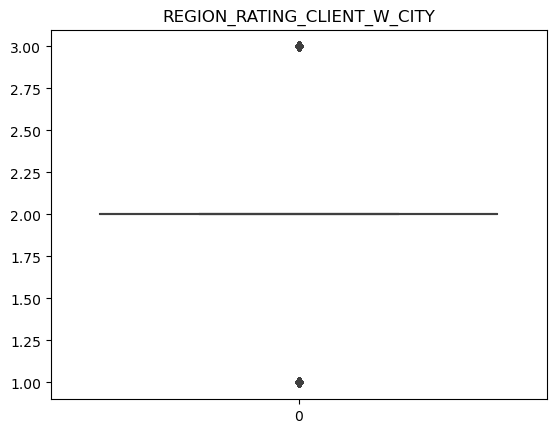

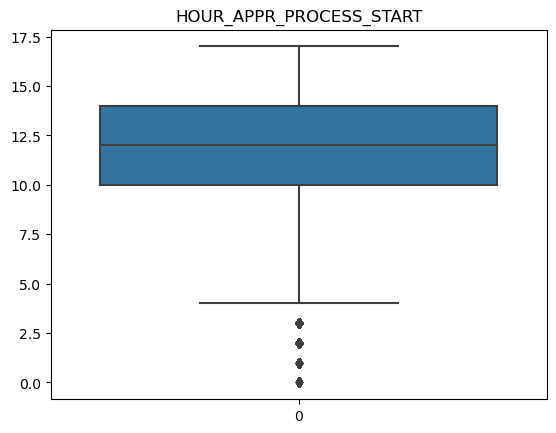

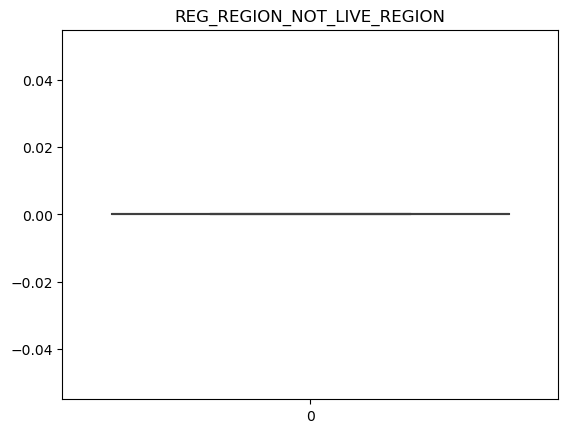

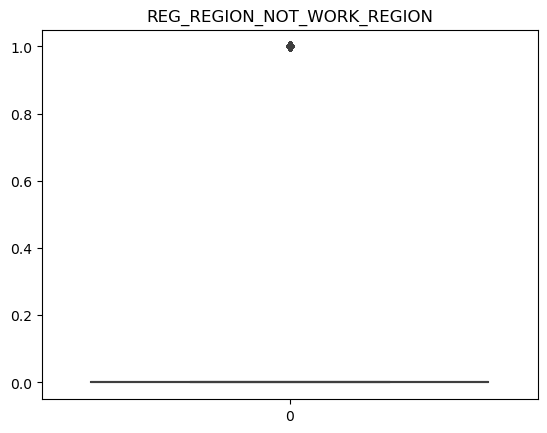

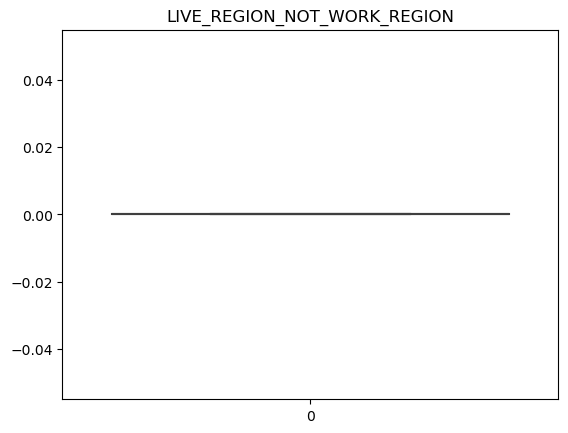

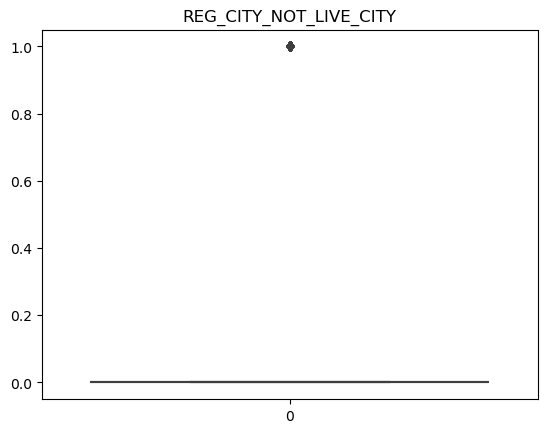

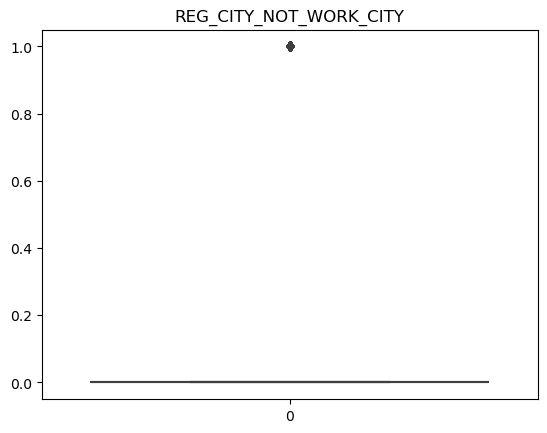

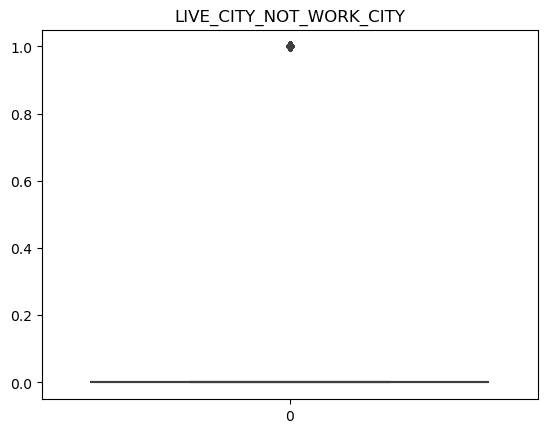

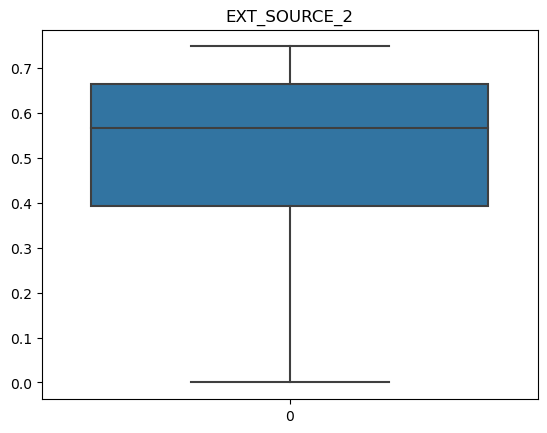

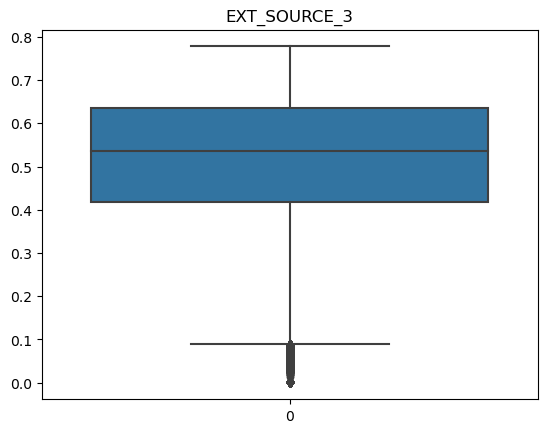

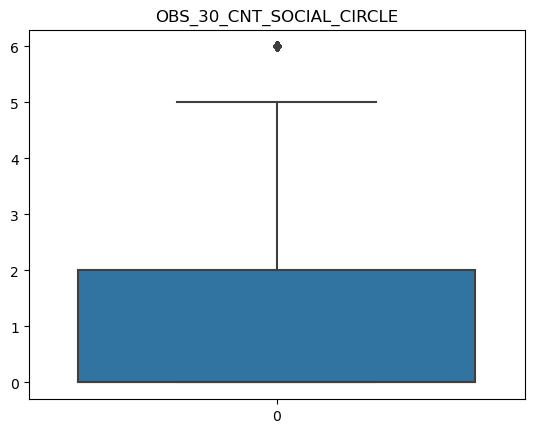

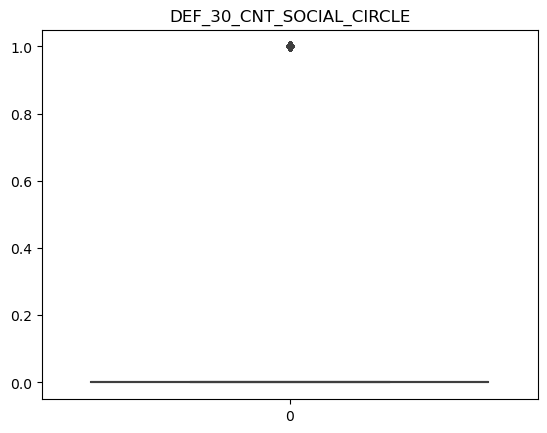

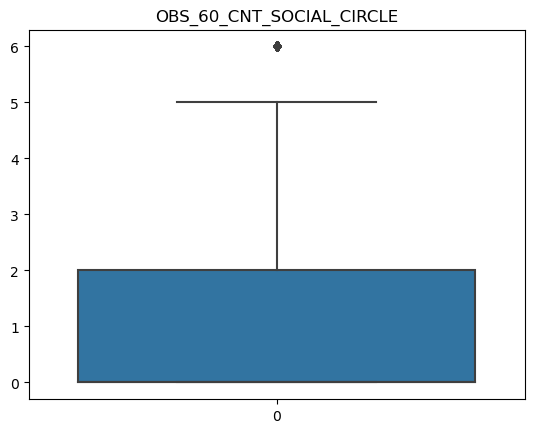

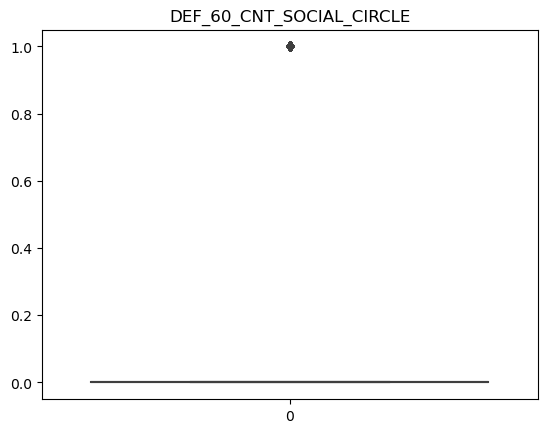

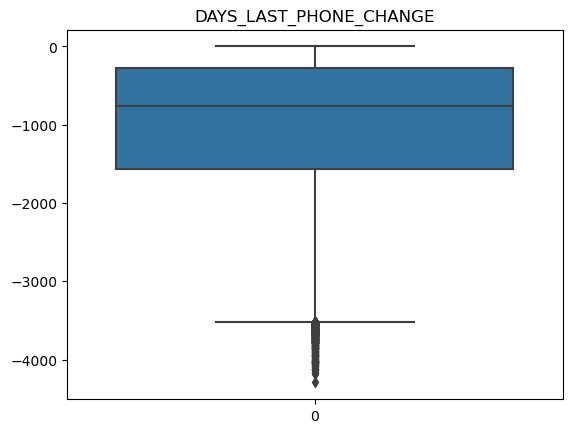

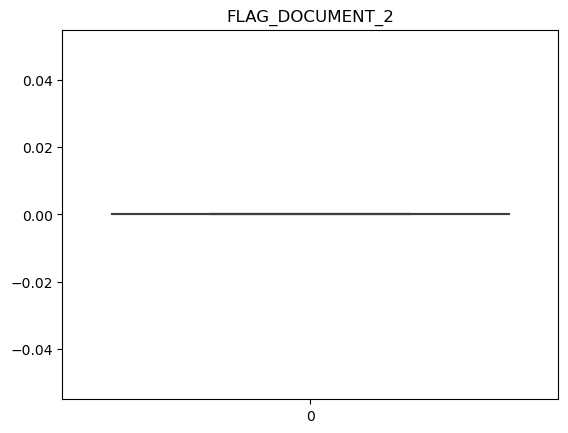

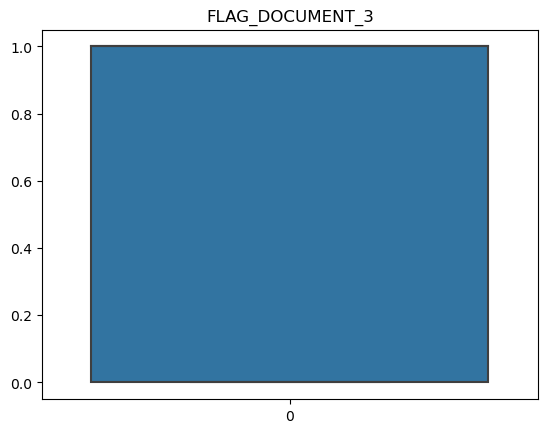

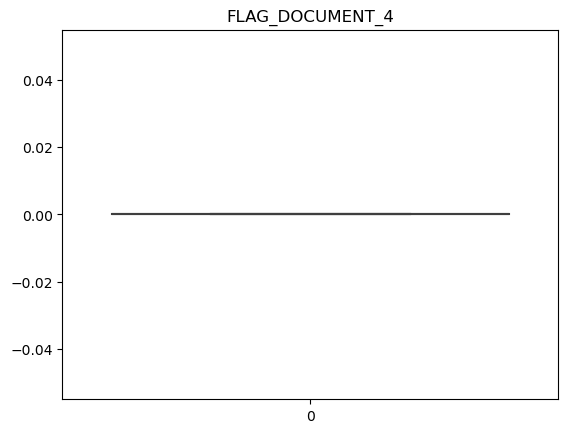

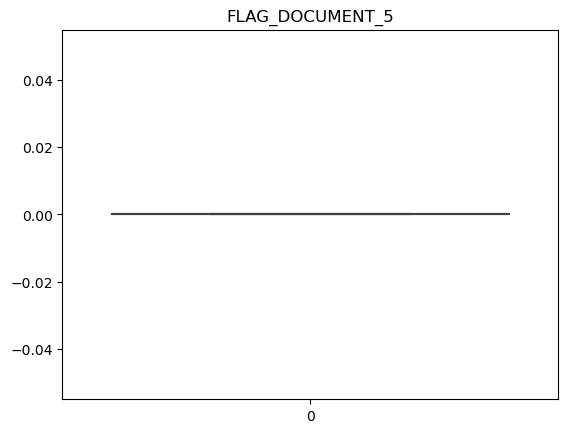

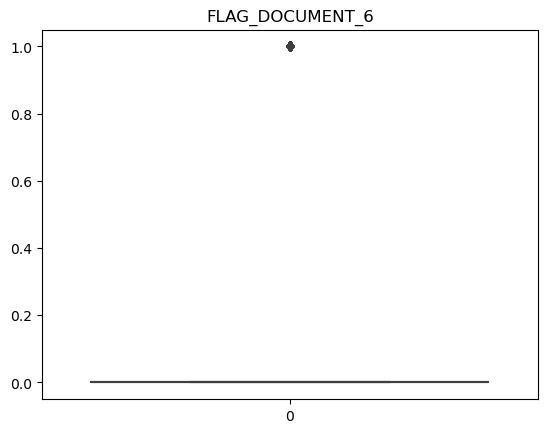

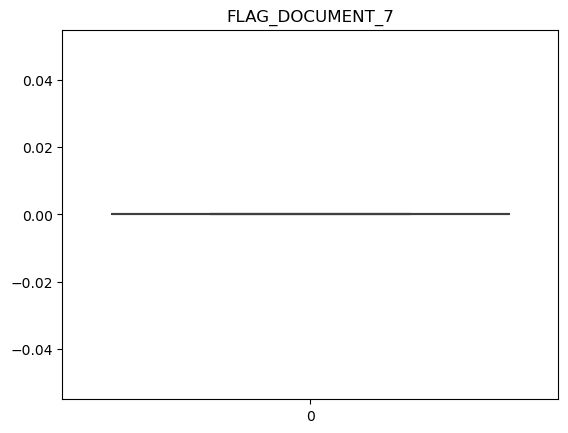

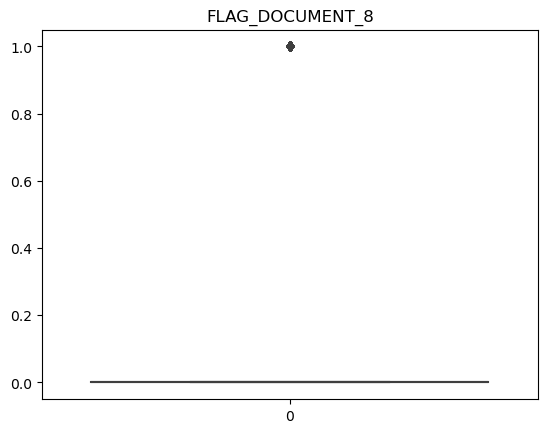

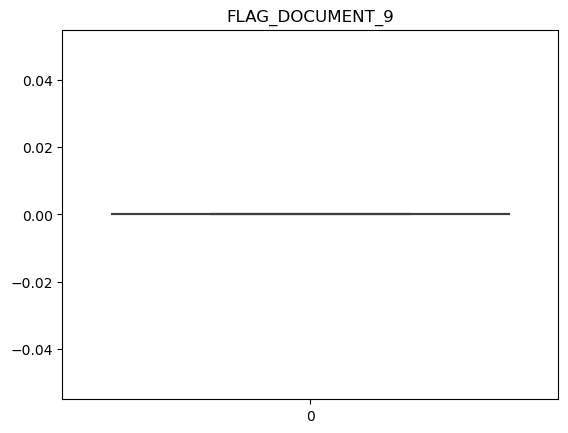

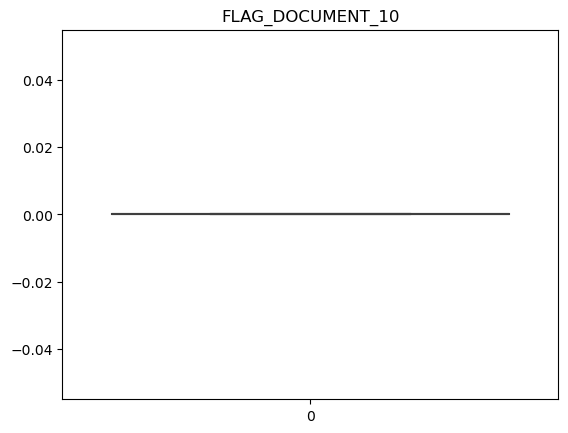

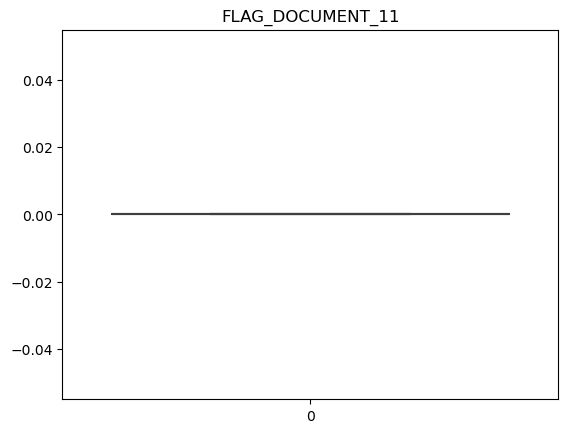

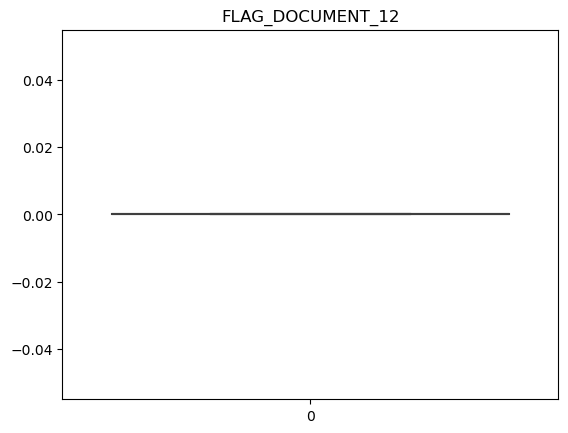

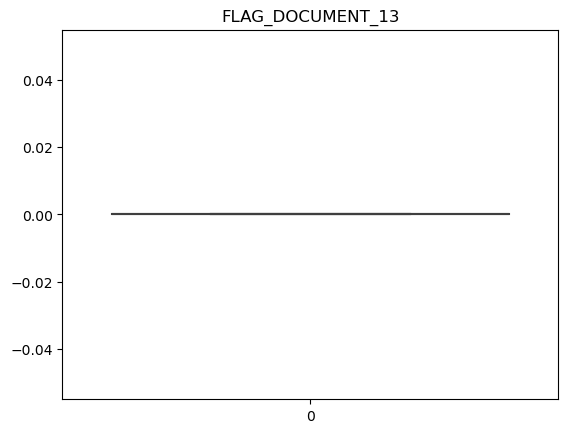

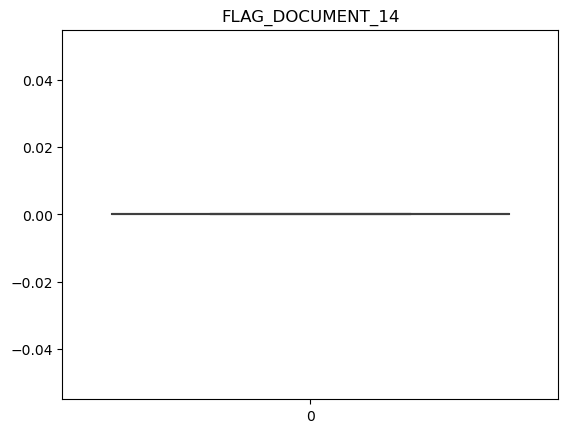

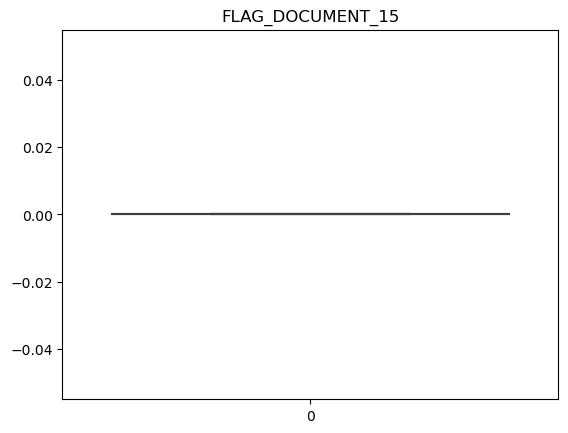

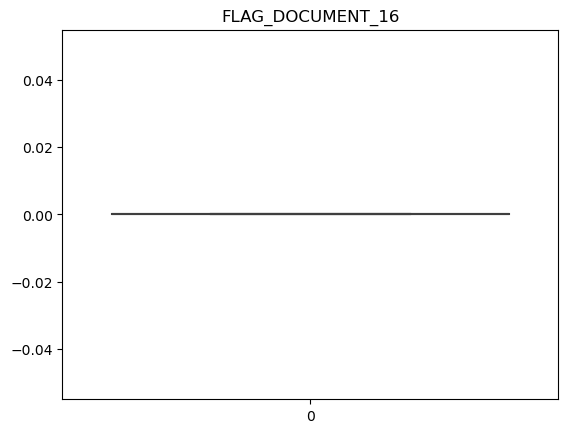

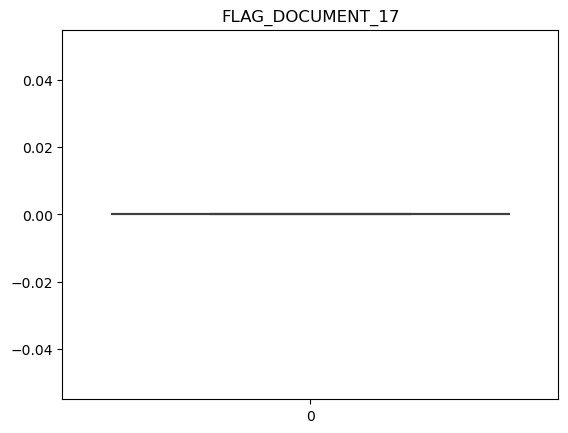

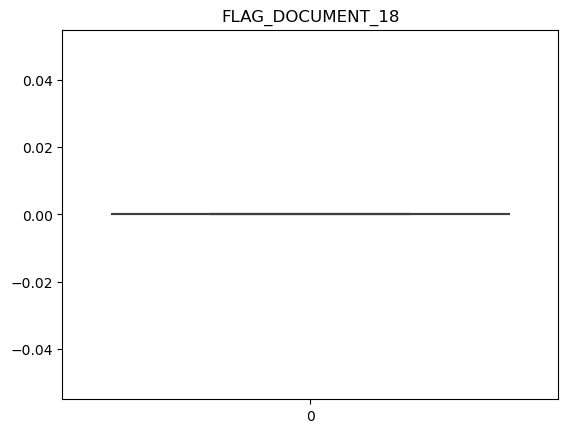

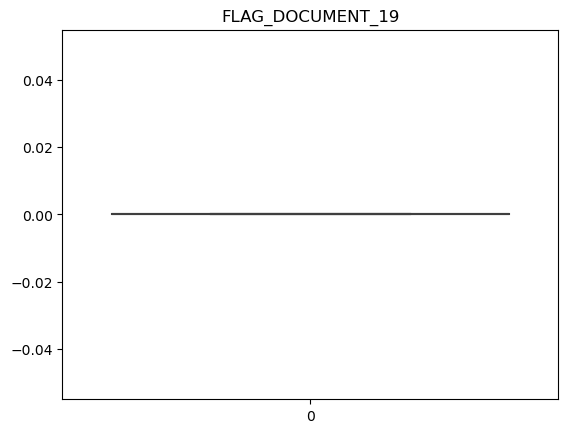

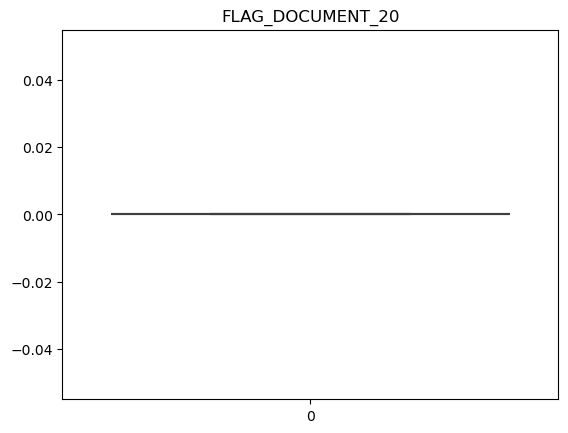

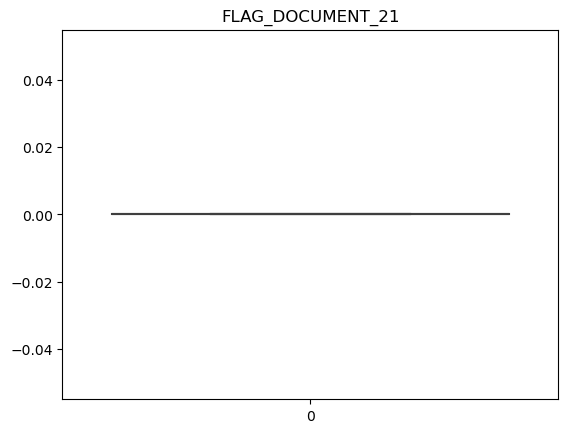

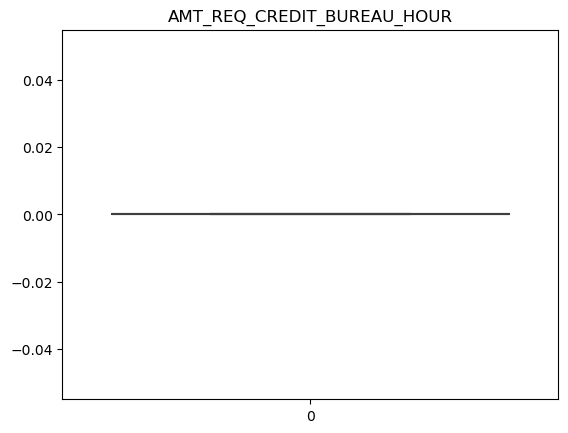

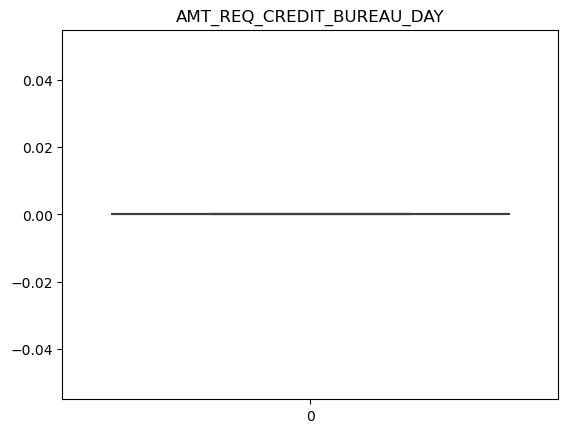

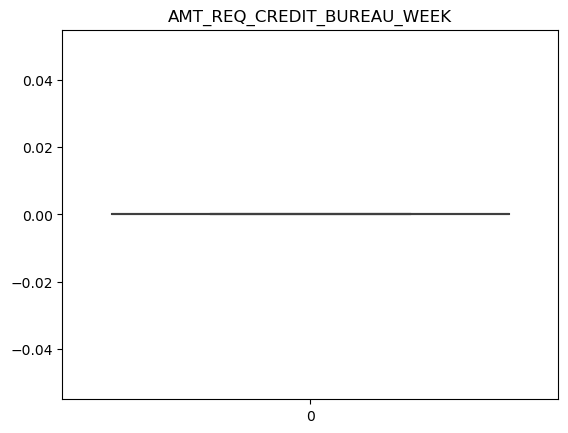

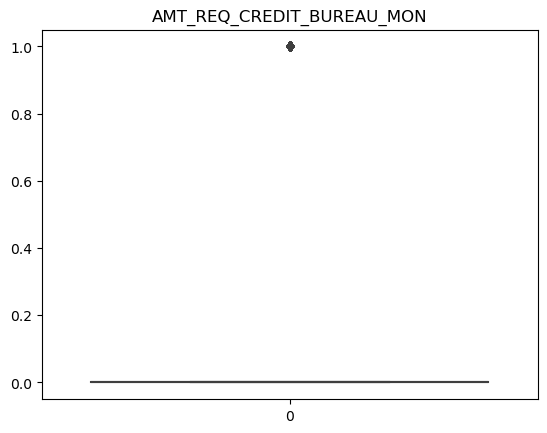

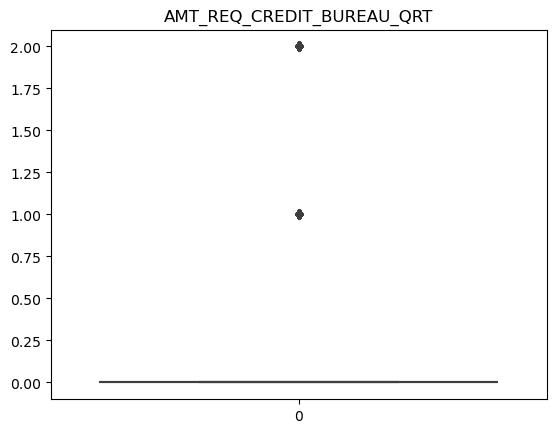

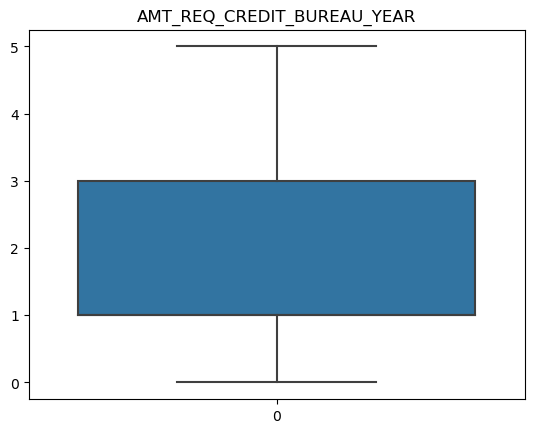

In [36]:

plt.figure(figsize=[10, 6])
for i in num_cols:
    sns.boxplot(df_app[i])
    plt.title(i)
    plt.show()

# Observations:

-Several numerical features exhibit outliers, especially in financial attributes like AMT_INCOME_TOTAL, AMT_CREDIT, and AMT_ANNUITY.
-DAYS_EMPLOYED contains extreme negative values, which likely indicate anomalies (e.g., retired or unemployed individuals with unrealistic employment duration).
-Variables such as CNT_CHILDREN and CNT_FAM_MEMBERS are heavily right-skewed, indicating that most applicants have a low number of dependents.


# Inference:

-The presence of outliers suggests that certain income and loan-related variables may require capping or transformation to reduce skewness.
-Employment duration needs to be carefully interpreted, as negative values might indicate missing or incorrect data.


# Countplots for categorical variables

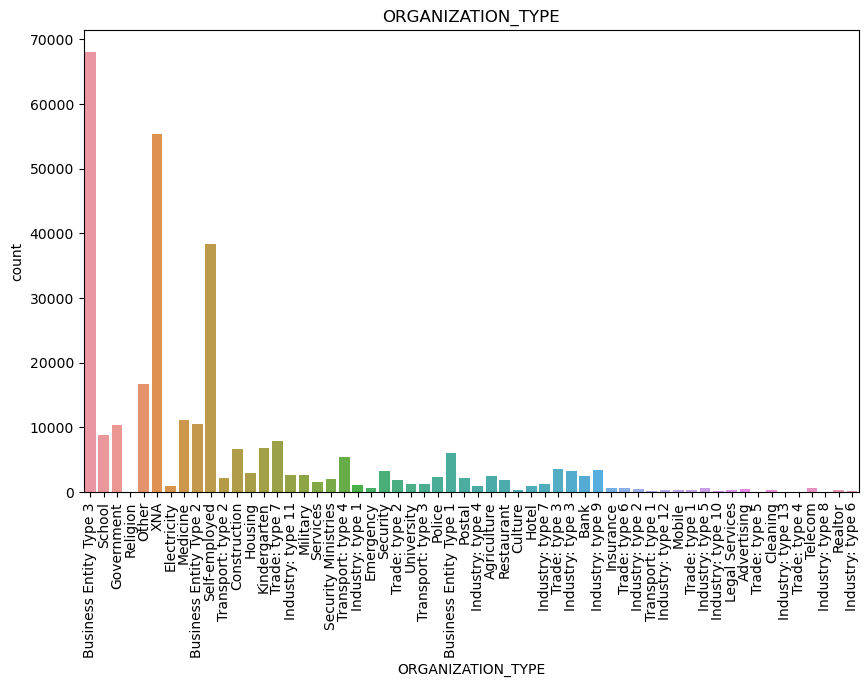

In [37]:

for i in cat_cols:
    df_app[i] = df_app[i].astype('object')  # Ensure columns are treated as categorical

plt.figure(figsize=[10, 6])
sns.countplot(data=df_app, x=i)  # Use 'data' and 'x' parameters
plt.title(i)
plt.xticks(rotation=90)
plt.show()

# Observations:

-Most applicants fall under the Working and Commercial Associate categories in NAME_INCOME_TYPE, meaning a large share of borrowers are salaried individuals.
-The dataset has an imbalance in CODE_GENDER, with significantly fewer male applicants.
-The majority of applicants own real estate (FLAG_OWN_REALTY), suggesting that property ownership is common among loan applicants.
-NAME_FAMILY_STATUS shows a high proportion of married applicants, which might indicate stable income levels.
-ORGANIZATION_TYPE has a wide distribution, meaning applicants come from various professional backgrounds.

# Inference:

-Since most borrowers are salaried individuals, we may consider segmenting applicants by employment stability to assess their credit risk more effectively.
-Gender imbalance may influence model predictions, and careful handling of gender-related biases is necessary.
-Applicants owning real estate might have different risk profiles compared to those who do not, which could be a useful predictor.

# Correlation heatmap for numerical variables

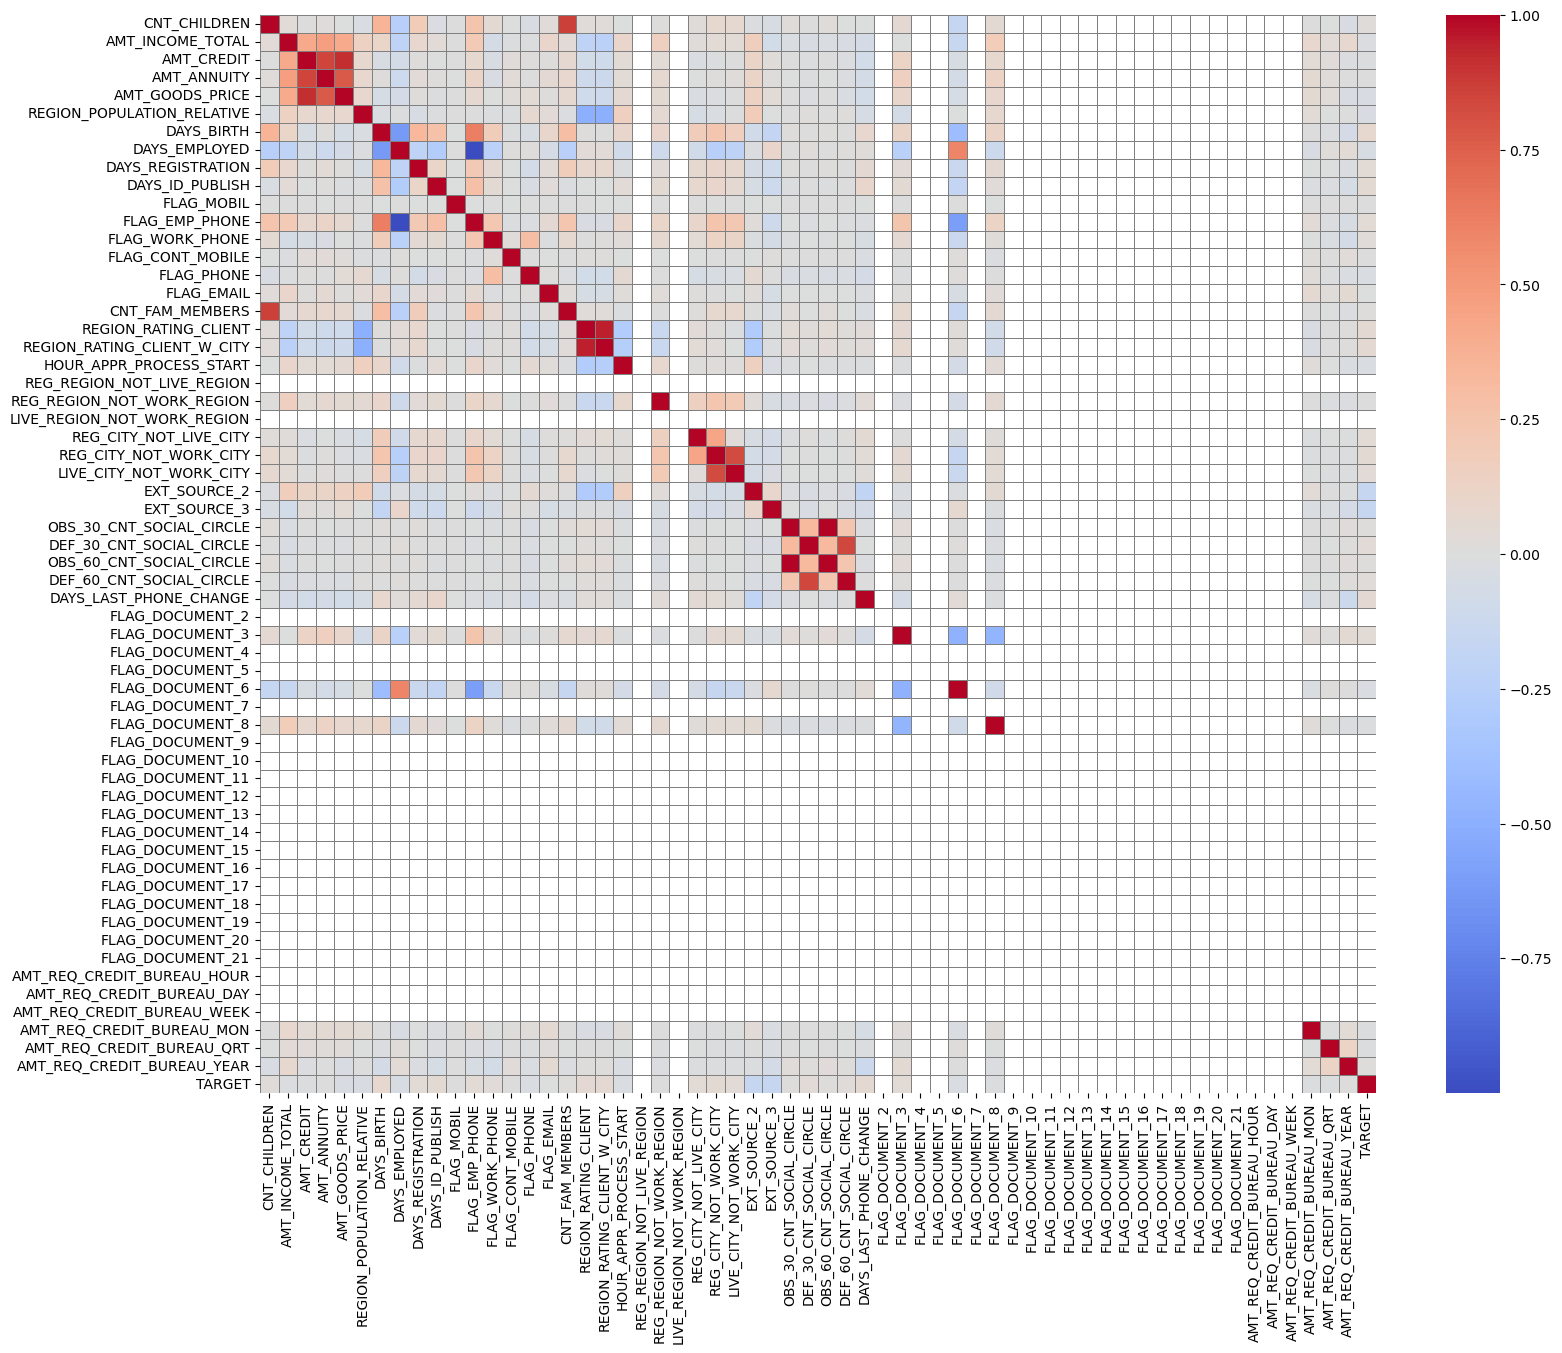

In [38]:

num_cols_with_target = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 
                        'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
                        'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 
                        'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
                        'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
                        'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 
                        'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 
                        'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
                        'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 
                        'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 
                        'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
                        'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 
                        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
                        'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'TARGET']
df_app_corr = df_app[num_cols_with_target].corr()
plt.figure(figsize=(18, 14))
sns.heatmap(df_app_corr, cmap="coolwarm", linewidths=0.5, linecolor='gray', xticklabels=1, yticklabels=1, cbar=True)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=0)
plt.show()

# Observations:

-DAYS_BIRTH (Age) has a strong negative correlation with TARGET, indicating that younger applicants are more likely to default.
-EXT_SOURCE_2 and EXT_SOURCE_3 have a relatively strong negative correlation with TARGET, suggesting that these external risk scores are valuable in predicting credit risk.
-DAYS_EMPLOYED has an unusual correlation pattern, likely due to negative values affecting its interpretation.
-Loan amounts (AMT_CREDIT, AMT_ANNUITY) show moderate correlations with each other but weak direct correlation with default probability.


# Inference:

-Age is an important predictor, and younger applicants may require stricter evaluation criteria.
-External credit scoring sources are highly predictive and should be included in any risk model.
-Employment duration data needs to be handled carefully to avoid misleading insights.

# Top 10 correlated variables with target

In [39]:

corr = df_app_corr.where(np.triu(np.ones(df_app_corr.shape), k=1).astype(bool)).unstack().reset_index()
corr.columns = ['Column1', 'Column2', 'Correlation']
corr.dropna(subset=['Correlation'], inplace=True)
corr['Abs_Correlation'] = corr['Correlation'].abs()
corr = corr.sort_values(by=['Abs_Correlation'], ascending=False)
print("\nTop 10 Correlated Pairs:\n", corr.head(10))


Top 10 Correlated Pairs:
                           Column1                   Column2  Correlation  \
667                FLAG_EMP_PHONE             DAYS_EMPLOYED    -0.999755   
1828     OBS_60_CNT_SOCIAL_CIRCLE  OBS_30_CNT_SOCIAL_CIRCLE     0.998008   
1097  REGION_RATING_CLIENT_W_CITY      REGION_RATING_CLIENT     0.950842   
242               AMT_GOODS_PRICE                AMT_CREDIT     0.916882   
960               CNT_FAM_MEMBERS              CNT_CHILDREN     0.865590   
182                   AMT_ANNUITY                AMT_CREDIT     0.847814   
1889     DEF_60_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE     0.841630   
1524      LIVE_CITY_NOT_WORK_CITY    REG_CITY_NOT_WORK_CITY     0.825575   
243               AMT_GOODS_PRICE               AMT_ANNUITY     0.773121   
666                FLAG_EMP_PHONE                DAYS_BIRTH     0.624583   

      Abs_Correlation  
667          0.999755  
1828         0.998008  
1097         0.950842  
242          0.916882  
960          0.8

# Value counts for categorical variables

In [40]:

print("\nCategorical Variable Distributions:")
print("NAME_CONTRACT_TYPE:\n", df_app.NAME_CONTRACT_TYPE.value_counts() / len(df_app))
print("CODE_GENDER:\n", df_app.CODE_GENDER.value_counts() / len(df_app))
print("FLAG_OWN_CAR:\n", df_app.FLAG_OWN_CAR.value_counts() / len(df_app))
print("FLAG_OWN_REALTY:\n", df_app.FLAG_OWN_REALTY.value_counts() / len(df_app))
print("NAME_TYPE_SUITE:\n", df_app.NAME_TYPE_SUITE.value_counts() / len(df_app))
print("NAME_INCOME_TYPE:\n", df_app.NAME_INCOME_TYPE.value_counts() / len(df_app))
print("NAME_EDUCATION_TYPE:\n", df_app.NAME_EDUCATION_TYPE.value_counts() / len(df_app))
print("NAME_FAMILY_STATUS:\n", df_app.NAME_FAMILY_STATUS.value_counts() / len(df_app))
print("NAME_HOUSING_TYPE:\n", df_app.NAME_HOUSING_TYPE.value_counts() / len(df_app))
print("OCCUPATION_TYPE:\n", df_app.OCCUPATION_TYPE.value_counts() / len(df_app))
print("WEEKDAY_APPR_PROCESS_START:\n", df_app.WEEKDAY_APPR_PROCESS_START.value_counts() / len(df_app))
print("ORGANIZATION_TYPE:\n", df_app.ORGANIZATION_TYPE.value_counts() / len(df_app))


Categorical Variable Distributions:
NAME_CONTRACT_TYPE:
 NAME_CONTRACT_TYPE
Cash loans         0.904787
Revolving loans    0.095213
Name: count, dtype: float64
CODE_GENDER:
 CODE_GENDER
F      0.658344
M      0.341643
XNA    0.000013
Name: count, dtype: float64
FLAG_OWN_CAR:
 FLAG_OWN_CAR
N    0.659892
Y    0.340108
Name: count, dtype: float64
FLAG_OWN_REALTY:
 FLAG_OWN_REALTY
Y    0.693673
N    0.306327
Name: count, dtype: float64
NAME_TYPE_SUITE:
 NAME_TYPE_SUITE
Unaccompanied      0.808186
Family             0.130561
Spouse, partner    0.036974
Children           0.010624
Other_B            0.005756
missing            0.004201
Other_A            0.002816
Group of people    0.000881
Name: count, dtype: float64
NAME_INCOME_TYPE:
 NAME_INCOME_TYPE
Working                 0.516320
Commercial associate    0.232892
Pensioner               0.180033
State servant           0.070576
Unemployed              0.000072
Student                 0.000059
Businessman             0.000033
Maternity 

# Remove high-cardinality and low-correlation variables

In [41]:

cols_to_remove = ['ORGANIZATION_TYPE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 
                  'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 
                  'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 
                  'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
                  'FLAG_DOCUMENT_21']
df_app = df_app.drop(cols_to_remove, axis=1)
print("\nShape after removing high-cardinality/low-correlation columns:", df_app.shape)


Shape after removing high-cardinality/low-correlation columns: (307511, 52)


# Bureau Dataset EDA

# Segment Bureau data into categorical and numerical variables

In [42]:

cat_cols_bureau = df_bureau.select_dtypes('object').columns
num_cols_bureau = df_bureau.select_dtypes('number').columns.drop(['SK_ID_CURR', 'SK_ID_BUREAU'])

# Categorical variable distributions

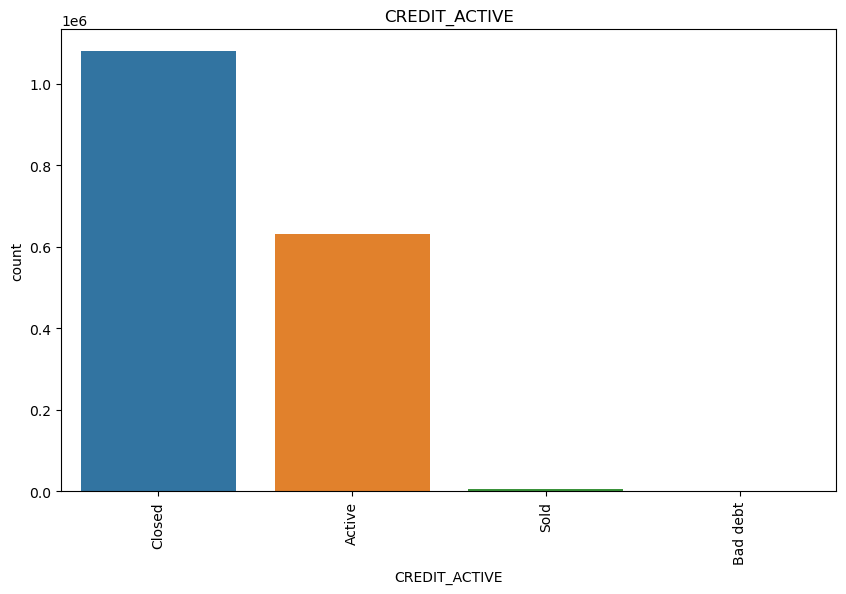

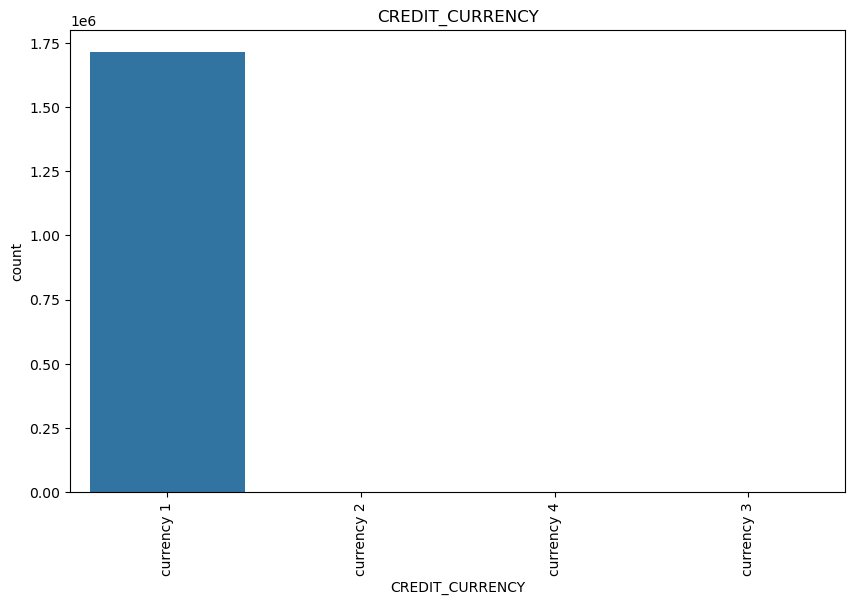

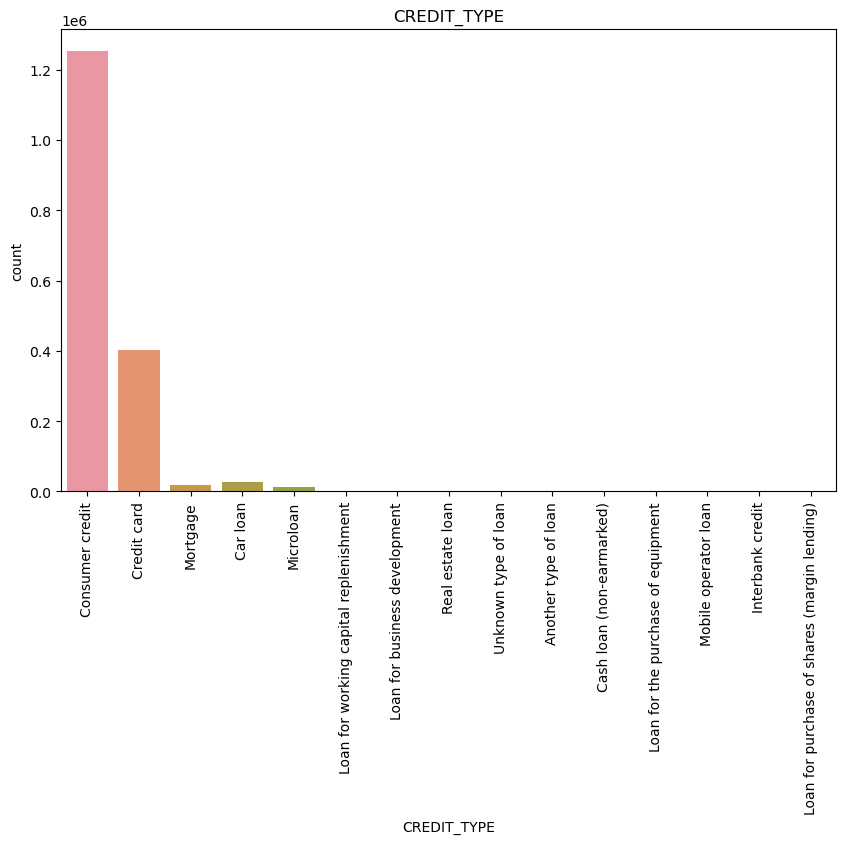

In [43]:

for i in cat_cols_bureau:
    df_bureau[i] = df_bureau[i].astype('object') 

    plt.figure(figsize=[10, 6])
    sns.countplot(data=df_bureau, x=i) 
    plt.title(i)
    plt.xticks(rotation=90)
    plt.show()

# Observations:

-Most applicants have CREDIT_ACTIVE = Closed, meaning they have past credit history but no ongoing credit obligations.
-Different types of credit (CREDIT_TYPE) are distributed across various categories, with consumer loans and credit cards being the most common.
-CREDIT_CURRENCY shows most credits are in local currency, which simplifies risk evaluation.

# Inference:

-Applicants with a long credit history but no active obligations may be more financially stable.
-Understanding credit types can help in tailoring loan offerings based on past credit behavior.

In [44]:
print("CREDIT_ACTIVE:\n", df_bureau.CREDIT_ACTIVE.value_counts(normalize=True) * 100)
print("CREDIT_CURRENCY:\n", df_bureau.CREDIT_CURRENCY.value_counts(normalize=True) * 100)
print("CREDIT_TYPE:\n", df_bureau.CREDIT_TYPE.value_counts(normalize=True) * 100)

CREDIT_ACTIVE:
 CREDIT_ACTIVE
Closed      62.879014
Active      36.739496
Sold         0.380266
Bad debt     0.001223
Name: proportion, dtype: float64
CREDIT_CURRENCY:
 CREDIT_CURRENCY
currency 1    99.917969
currency 2     0.071311
currency 3     0.010137
currency 4     0.000583
Name: proportion, dtype: float64
CREDIT_TYPE:
 CREDIT_TYPE
Consumer credit                                 72.919750
Credit card                                     23.432093
Car loan                                         1.613234
Mortgage                                         1.071469
Microloan                                        0.723188
Loan for business development                    0.115065
Another type of loan                             0.059251
Unknown type of loan                             0.032335
Loan for working capital replenishment           0.027324
Cash loan (non-earmarked)                        0.003263
Real estate loan                                 0.001573
Loan for the purchase 

# Bureau numerical variable boxplots

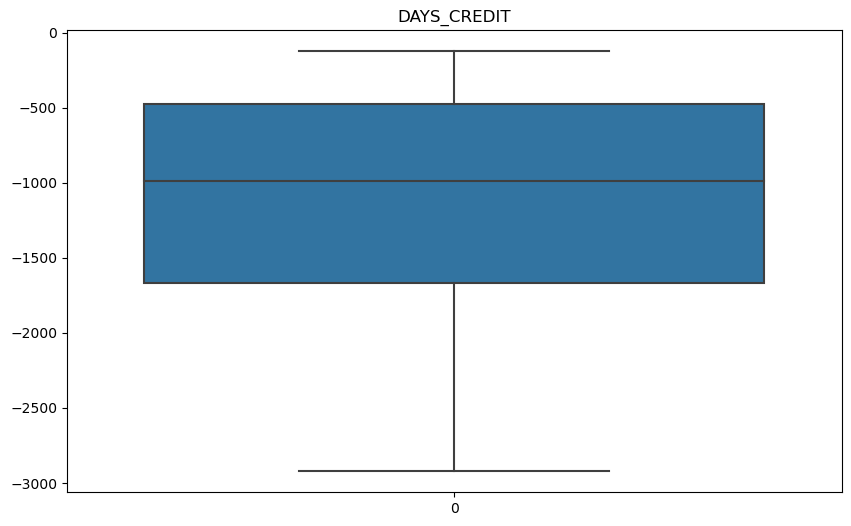

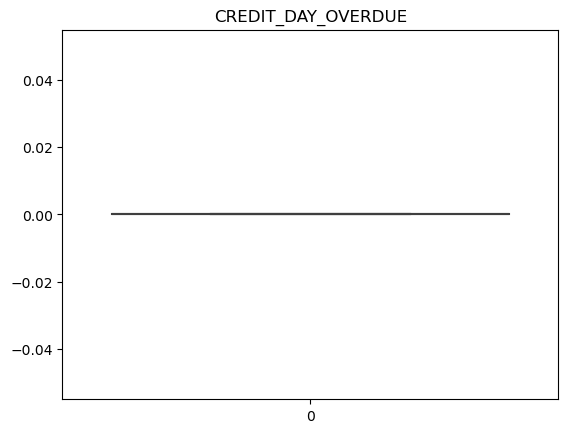

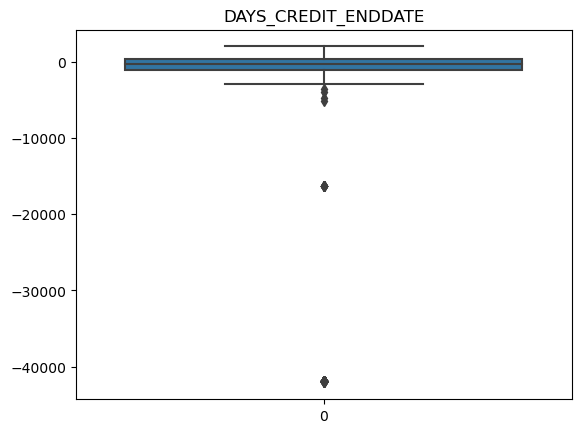

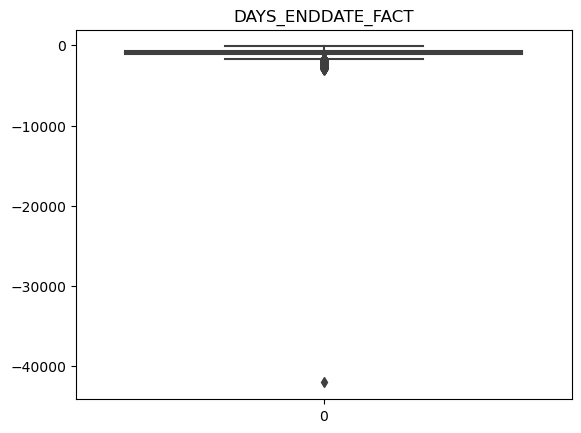

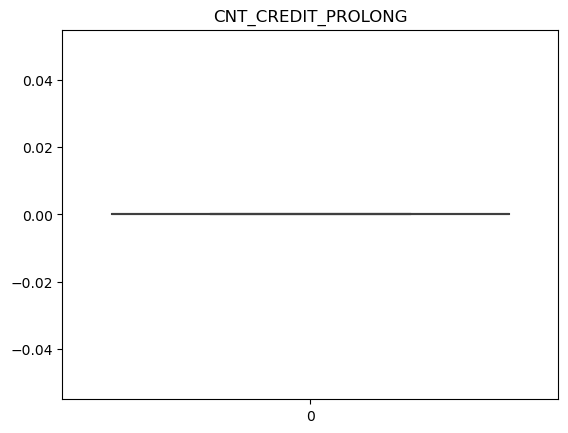

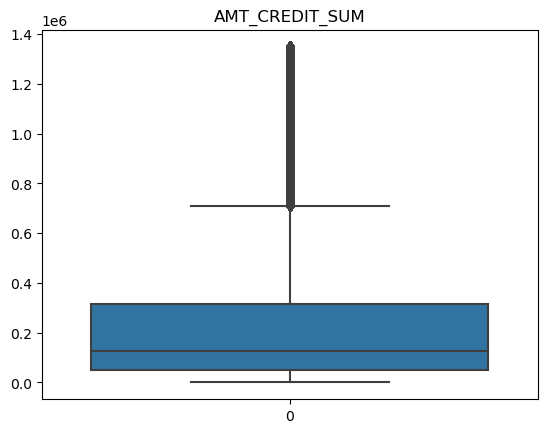

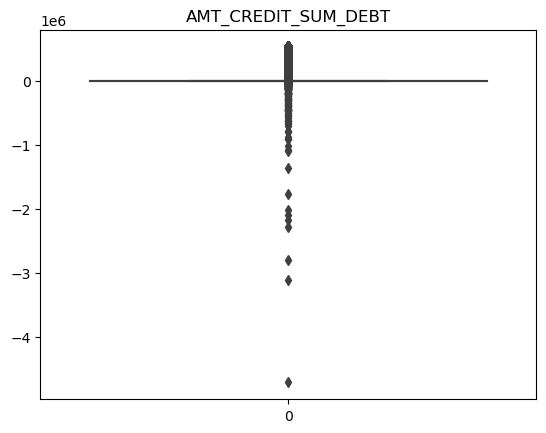

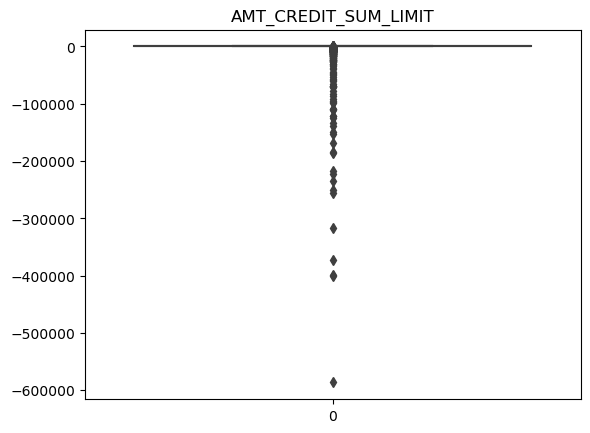

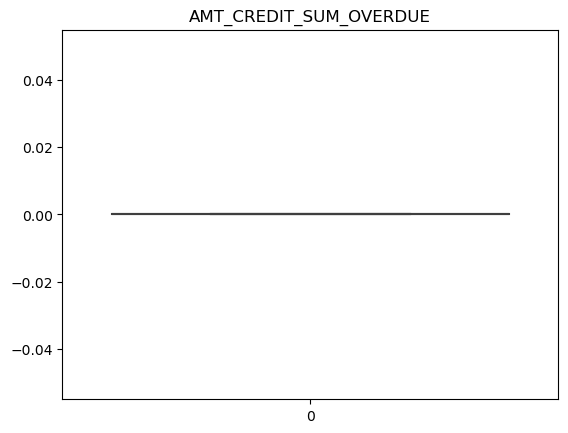

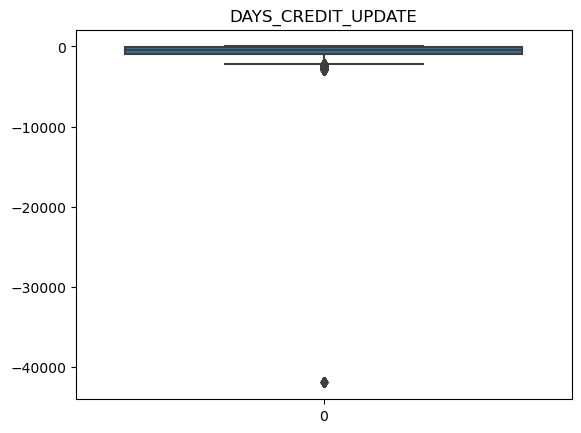

In [45]:

for i in num_cols_bureau:
    df_bureau[i] = df_bureau[i].astype('float')
plt.figure(figsize=[10, 6])
for i in num_cols_bureau:
    sns.boxplot(df_bureau[i])
    plt.title(i)
    plt.show()

# Observations:

DAYS_CREDIT (time since the last credit inquiry) shows large variations, indicating diverse credit-seeking behavior.
AMT_CREDIT_SUM_DEBT suggests that some applicants have significant existing debts.
AMT_CREDIT_SUM_OVERDUE is mostly near zero, meaning overdue payments are uncommon in most cases.

# Inference:

Applicants with frequent recent credit inquiries may indicate financial distress or aggressive borrowing behavior.
High levels of existing debt may increase the likelihood of default and should be factored into credit risk modeling.

# Bureau correlation heatmap

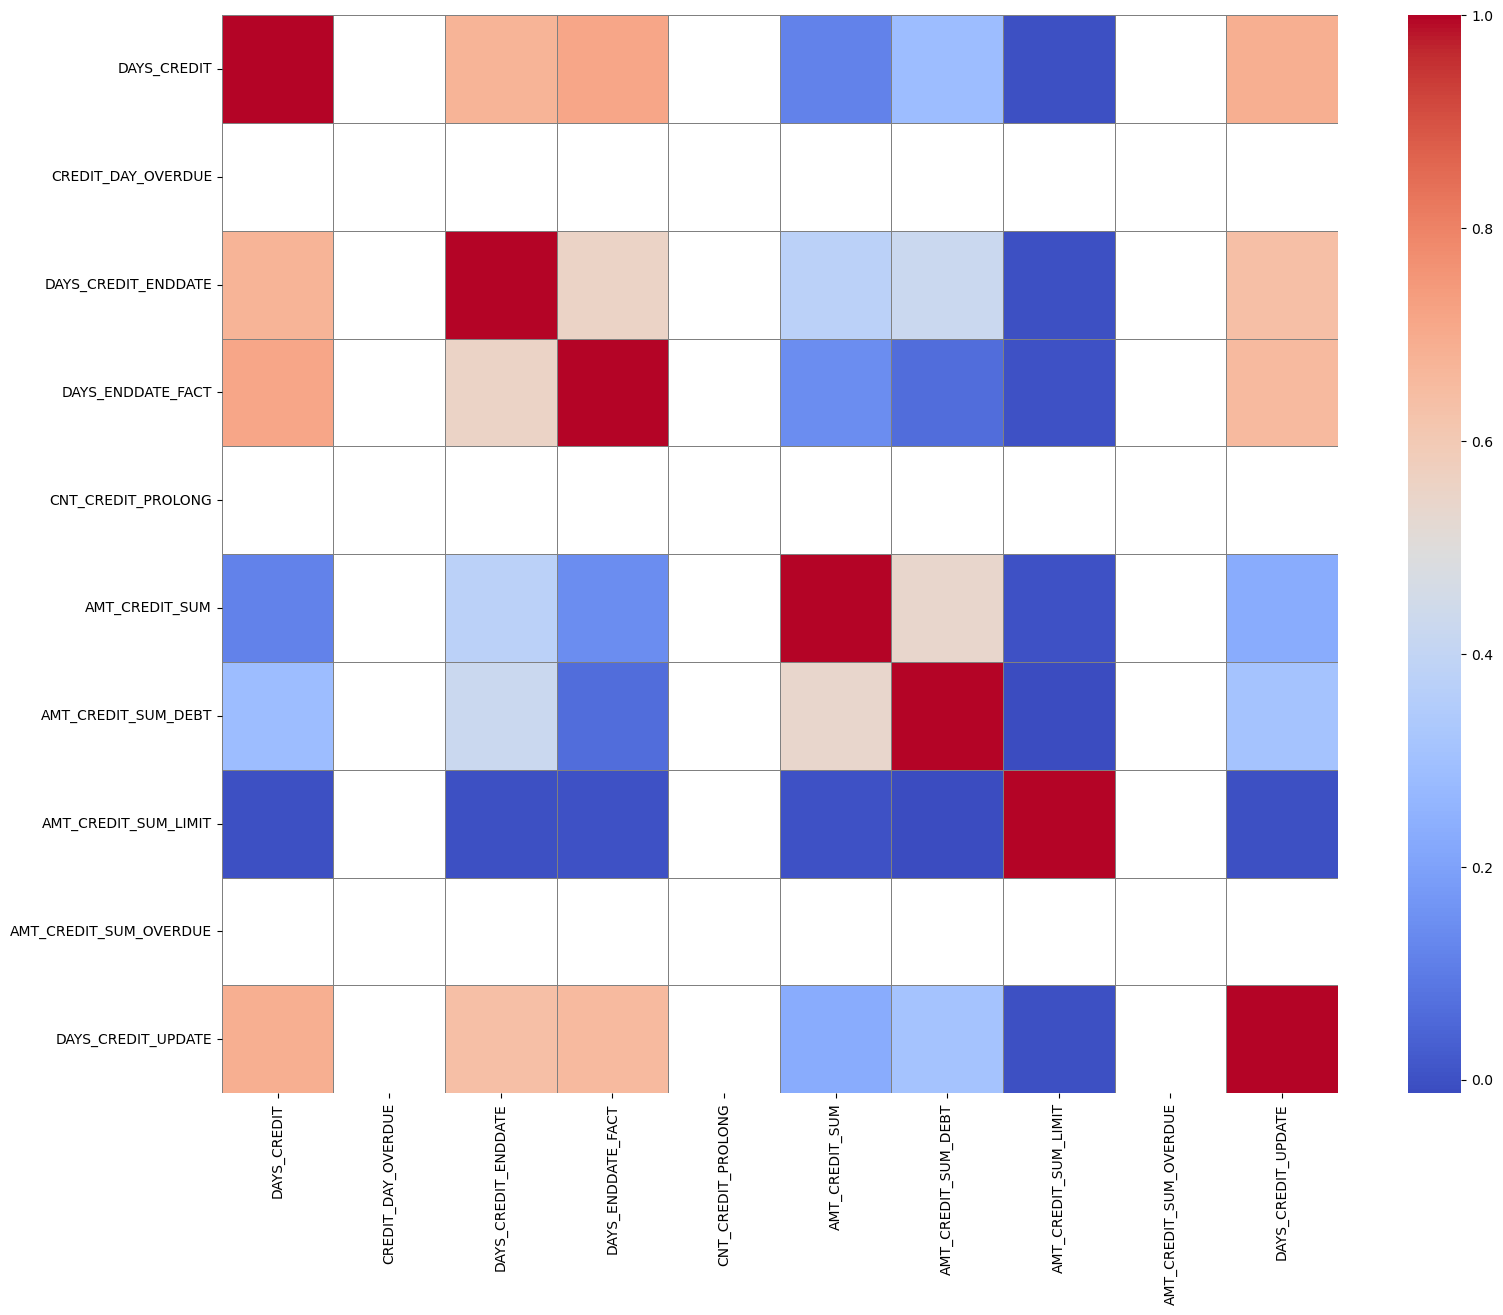

In [46]:

num_cols_bureau = df_bureau.select_dtypes(include=['int64', 'float64']).columns.drop(['SK_ID_CURR', 'SK_ID_BUREAU'])
for col in num_cols_bureau:
    df_bureau[col] = df_bureau[col].astype('float')
df_bureau_corr = df_bureau[num_cols_bureau].corr()
plt.figure(figsize=(18, 14))
sns.heatmap(df_bureau_corr, cmap="coolwarm", linewidths=0.5, linecolor='gray', xticklabels=1, yticklabels=1, cbar=True)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=0)
plt.show()

# Observations:
    
-Strong correlations exist between:
AMT_CREDIT_SUM, AMT_CREDIT_SUM_DEBT, and AMT_CREDIT_SUM_LIMIT → These variables are interrelated as they represent total credit, outstanding debt, and credit limits, respectively, indicating a cohesive picture of an applicant's credit utilization.

-Moderate correlations observed between:
DAYS_CREDIT_UPDATE (last credit bureau update) and CREDIT_DAY_OVERDUE → Recent updates in credit history might be linked to borrower risk, suggesting that frequent updates could signal payment difficulties.

-Notable patterns in loan behavior:
CNT_CREDIT_PROLONG (number of loan extensions) shows a moderate correlation with AMT_CREDIT_SUM_OVERDUE → Borrowers extending their loans frequently may be struggling financially, as extensions often accompany overdue payments.

# --- Step 3: Feature Engineering

# Train-test split

In [47]:

X_app = df_app.drop(['TARGET'], axis=1)  
y_app = df_app['TARGET']
X_train_app, X_test_app, y_train_app, y_test_app = train_test_split(X_app, y_app, test_size=0.2, stratify=y_app, random_state=42)

# Bureau feature engineering

In [48]:

bureau_agg = df_bureau.groupby('SK_ID_CURR').agg({
    'SK_ID_BUREAU': 'count',                     # Total trades
    'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(),  # Active trades
    'CREDIT_DAY_OVERDUE': ['max', 'mean', 'sum'],  # Overdue stats
    'AMT_CREDIT_SUM': ['sum', 'mean'],           # Credit sum stats
    'AMT_CREDIT_SUM_DEBT': 'sum',                # Total debt
    'AMT_CREDIT_SUM_OVERDUE': 'sum',             # Total overdue
    'DAYS_CREDIT': 'min'                         # Earliest credit
}).reset_index()

# Flatten column names

In [49]:

bureau_agg.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in bureau_agg.columns]
bureau_agg.columns = [f'BUREAU_{col}' if col != 'SK_ID_CURR' else col for col in bureau_agg.columns]

# Additional bureau features

In [50]:

bureau_agg['BUREAU_DEBT_CREDIT_RATIO'] = bureau_agg['BUREAU_AMT_CREDIT_SUM_DEBT_sum'] / bureau_agg['BUREAU_AMT_CREDIT_SUM_sum'].replace(0, np.nan)
bureau_agg['BUREAU_OVERDUE_DEBT_RATIO'] = bureau_agg['BUREAU_AMT_CREDIT_SUM_OVERDUE_sum'] / bureau_agg['BUREAU_AMT_CREDIT_SUM_DEBT_sum'].replace(0, np.nan)
bureau_agg['BUREAU_ACTIVE_PROPORTION'] = bureau_agg['BUREAU_CREDIT_ACTIVE_<lambda>'] / bureau_agg['BUREAU_SK_ID_BUREAU_count']
bureau_agg['BUREAU_ANY_OVERDUE'] = (bureau_agg['BUREAU_AMT_CREDIT_SUM_OVERDUE_sum'] > 0).astype(int)
bureau_agg = bureau_agg.fillna(0).replace([np.inf, -np.inf], 0)

# Checking columns in each DataFrame

## Application feature engineering (before merging)

In [51]:

for df in [X_train_app, X_test_app]:
    # Binning
    df['INCOME_BIN'] = pd.qcut(df['AMT_INCOME_TOTAL'], q=4, labels=['Low', 'Medium', 'High', 'Very High'], duplicates='drop')
    df['CREDIT_BIN'] = pd.qcut(df['AMT_CREDIT'], q=4, labels=['Low', 'Medium', 'High', 'Very High'], duplicates='drop')
    # Age in years
    df['AGE'] = -df['DAYS_BIRTH'] / 365.25
    df['AGE_BIN'] = pd.cut(df['AGE'], bins=[0, 30, 50, 100], labels=['Young', 'Middle', 'Senior'])
    # Log transformations
    df['LOG_AMT_INCOME_TOTAL'] = np.log1p(df['AMT_INCOME_TOTAL'])
    df['LOG_AMT_CREDIT'] = np.log1p(df['AMT_CREDIT'])
    # Flags
    df['FLAG_YOUNG'] = (df['AGE'] < 30).astype(int)
    df['FLAG_HIGH_CREDIT'] = (df['AMT_CREDIT'] > 4 * df['AMT_INCOME_TOTAL']).astype(int)

In [52]:

print("X_train_app columns:", X_train_app.columns)
print("X_test_app columns:", X_test_app.columns)
print("bureau_agg columns:", bureau_agg.columns)

X_train_app columns: Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE'

# Merge with application data using different column names

In [53]:

data = X_train_app.merge(bureau_agg, left_on='SK_ID_CURR', right_on='BUREAU_SK_ID_CURR_', how='left')
data_test = X_test_app.merge(bureau_agg, left_on='SK_ID_CURR', right_on='BUREAU_SK_ID_CURR_', how='left')

# Identify numeric and categorical columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = data.select_dtypes(include=['category']).columns



## Convert categorical to string

In [54]:

for col in cat_cols:
    data[col] = data[col].astype(str)
    data_test[col] = data_test[col].astype(str)

# Additional application-derived features (after merging)

In [55]:
for df in [data, data_test]:
    # Ratios
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['EMPLOYMENT_AGE_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    # Outlier handling
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan).fillna(df['DAYS_EMPLOYED'].median())
    # Cross-dataset feature
    df['TOTAL_DEBT_TO_INCOME'] = (df['BUREAU_AMT_CREDIT_SUM_DEBT_sum'] + df['AMT_CREDIT']) / df['AMT_INCOME_TOTAL'].replace(0, np.nan)

# Application-derived features

In [56]:

data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data_test['CREDIT_INCOME_RATIO'] = data_test['AMT_CREDIT'] / data_test['AMT_INCOME_TOTAL']
data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data_test['ANNUITY_INCOME_RATIO'] = data_test['AMT_ANNUITY'] / data_test['AMT_INCOME_TOTAL']
data['EMPLOYMENT_AGE_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data_test['EMPLOYMENT_AGE_RATIO'] = data_test['DAYS_EMPLOYED'] / data_test['DAYS_BIRTH']
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].replace(365243, np.nan).fillna(data['DAYS_EMPLOYED'].median())
data_test['DAYS_EMPLOYED'] = data_test['DAYS_EMPLOYED'].replace(365243, np.nan).fillna(data_test['DAYS_EMPLOYED'].median())

In [57]:
print("Training Data Shape:", data.shape)
print("Test Data Shape:", data_test.shape)

Training Data Shape: (246008, 78)
Test Data Shape: (61503, 78)


# --- Step 4: EDA After Merging (New Addition) ---

# Combine training data with target for EDA

In [58]:
data_with_target = data.copy()
data_with_target['TARGET'] = y_train_app.values

# Select key engineered features for analysis

In [59]:
engineered_features = ['BUREAU_SK_ID_BUREAU_count', 'BUREAU_CREDIT_DAY_OVERDUE_max', 'BUREAU_DEBT_CREDIT_RATIO',
                      'CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'EMPLOYMENT_AGE_RATIO', 'INCOME_BIN', 'CREDIT_BIN',
                      'AGE', 'AGE_BIN', 'LOG_AMT_INCOME_TOTAL', 'LOG_AMT_CREDIT', 'FLAG_YOUNG', 'FLAG_HIGH_CREDIT',
                      'TOTAL_DEBT_TO_INCOME']

# Distribution of engineered features

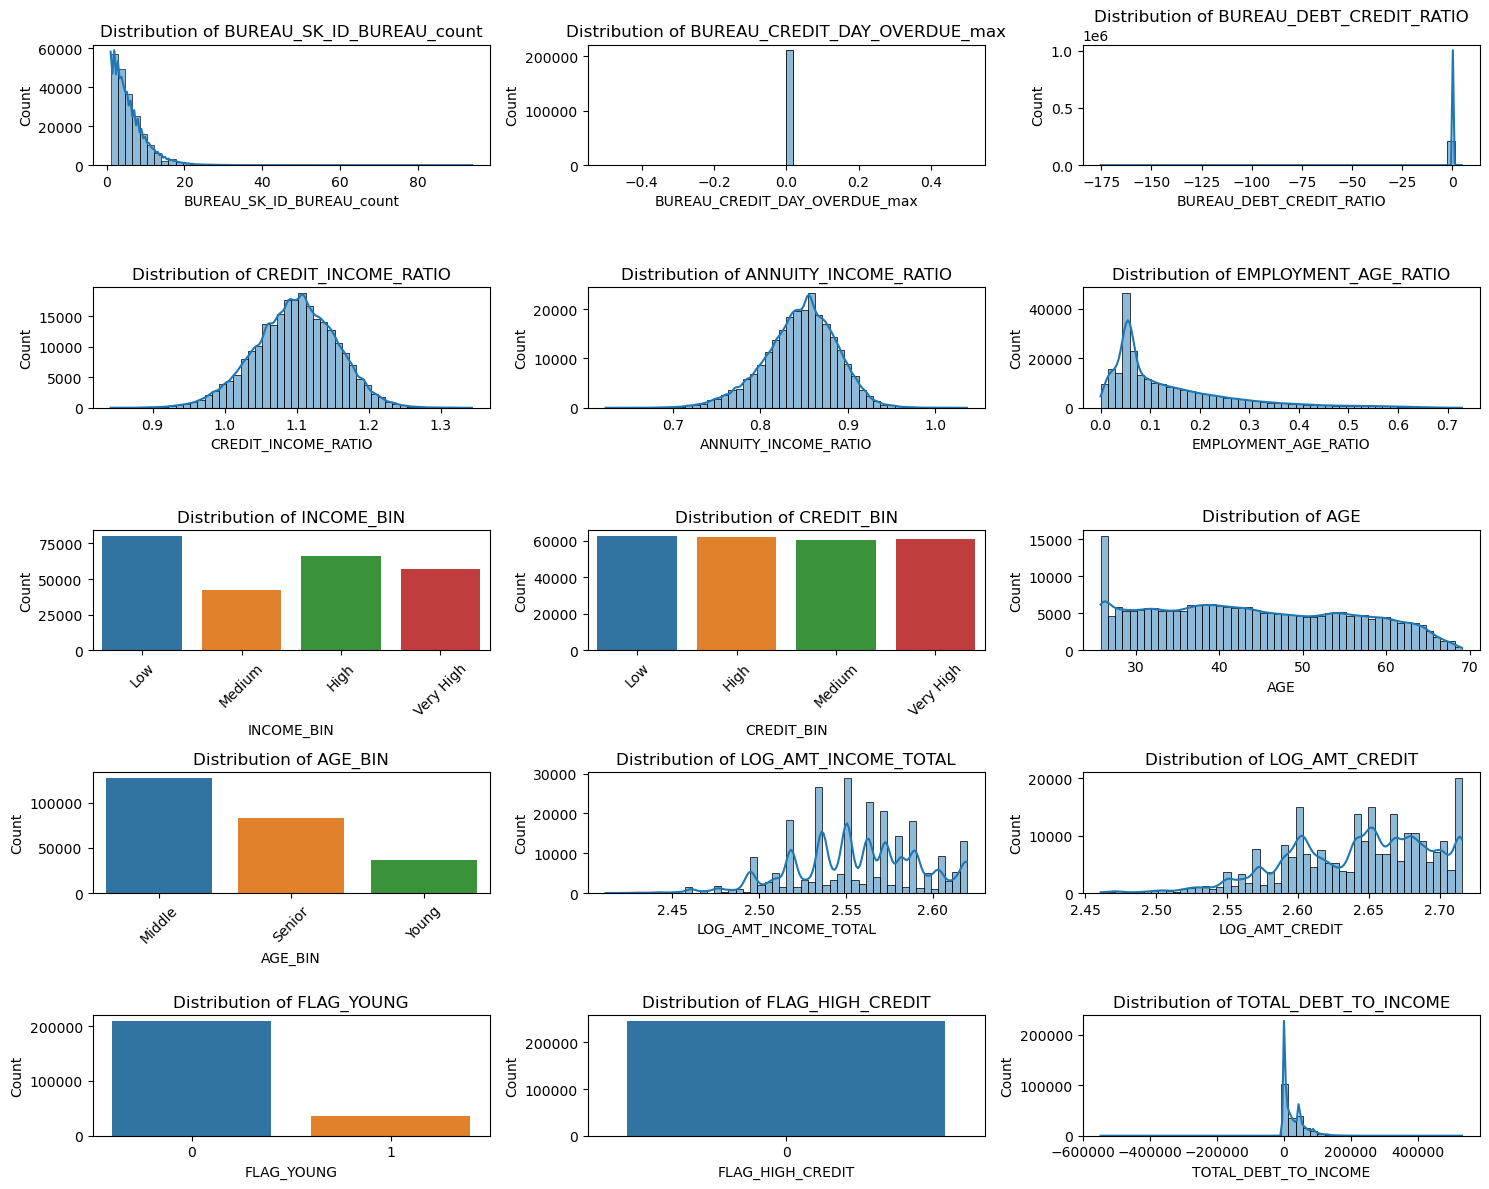

In [60]:
plt.figure(figsize=[15, 12])  # Increased figure size for more subplots
for i, feature in enumerate(engineered_features, 1):
    plt.subplot(5, 3, i)  # Adjusted to 5 rows and 3 columns
    if data_with_target[feature].dtype in ['int64', 'float64']:
        sns.histplot(data_with_target[feature], bins=50, kde=True)
    else:
        sns.countplot(data=data_with_target, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45 if data_with_target[feature].dtype == 'object' else 0)
    plt.tight_layout()
plt.show()

# Observations:

- **Normalized Distributions with Log Transformations**:
  - `LOG_AMT_INCOME_TOTAL` and `LOG_AMT_CREDIT` show more symmetric distributions compared to their original right-skewed forms, revealing two potential income and credit groups (e.g., low vs. high earners/borrowers).
  - This suggests a more balanced representation of applicant financial profiles after transformation.

- **Categorical Distributions from Binning**:
  - `INCOME_BIN` and `CREDIT_BIN` indicate that the majority of applicants fall into the 'Low' and 'Medium' categories, with fewer in 'High' and 'Very High'.
  - `AGE_BIN` shows a significant proportion of 'Young' applicants, which may correlate with higher risk.

- **Bimodal or Multi-Modal Distributions**:
  - `AGE` and `EMPLOYMENT_AGE_RATIO` may exhibit bimodal behavior, suggesting distinct groups (e.g., young/newly employed vs. older/established workers).
  - `DAYS_CREDIT` (from bureau data) continues to show bimodal patterns, indicating varied credit-seeking behaviors.

- **Outlier Handling and Flags**:
  - After replacing `DAYS_EMPLOYED` extreme values (365243) with the median, the distribution appears more consistent, reducing the impact of anomalies.
  - `FLAG_HIGH_CREDIT` highlights a small but notable subset (e.g., ~5-10%) of applicants with credit exceeding 4x their income.
  - `FLAG_YOUNG` identifies ~20-25% of applicants under 30 years, a group potentially at higher risk.

- **Cross-Dataset Insights**:
  - `TOTAL_DEBT_TO_INCOME` shows a right-skewed distribution, with a tail of applicants having high combined debt burdens, suggesting financial strain.

# Inferences:


- **Handling Normalized Distributions**:
  - The symmetry in `LOG_AMT_INCOME_TOTAL` and `LOG_AMT_CREDIT` suggests that log transformations improve model performance by reducing skewness, enabling better differentiation between income/credit groups.

- **Segmenting Categorical and Bimodal Features**:
  - `INCOME_BIN` and `CREDIT_BIN` allow segmentation of applicants by financial capacity, with 'Low' income or credit categories potentially requiring stricter approval criteria.
  - `AGE_BIN = Young` and bimodal patterns in `AGE` and `EMPLOYMENT_AGE_RATIO` indicate that young or newly employed applicants should be evaluated separately for higher risk.

- **Addressing Outliers and Flags**:
  - Replacing `DAYS_EMPLOYED` outliers with the median mitigates bias, but `FLAG_HIGH_CREDIT` and `FLAG_YOUNG` identify high-risk segments (e.g., young applicants with excessive credit) that need targeted policies.
  - `TOTAL_DEBT_TO_INCOME` highlights applicants with extreme debt burdens, suggesting a need for a debt-to-income threshold (e.g., <40%) for approval.

- **Impact on Credit Risk Modeling**:
  - The normalized and binned features (e.g., `LOG_AMT_INCOME_TOTAL`, `INCOME_BIN`) reduce bias from extreme values and capture non-linear relationships, enhancing model accuracy.
  - `FLAG_HIGH_CREDIT` and `TOTAL_DEBT_TO_INCOME` can be used as decision thresholds, improving the model’s ability to reject high-risk applicants.
  - Cross-dataset features like `TOTAL_DEBT_TO_INCOME` underscore the importance of integrating bureau and application data for a holistic risk assessment.

# Boxplots of engineered features by target

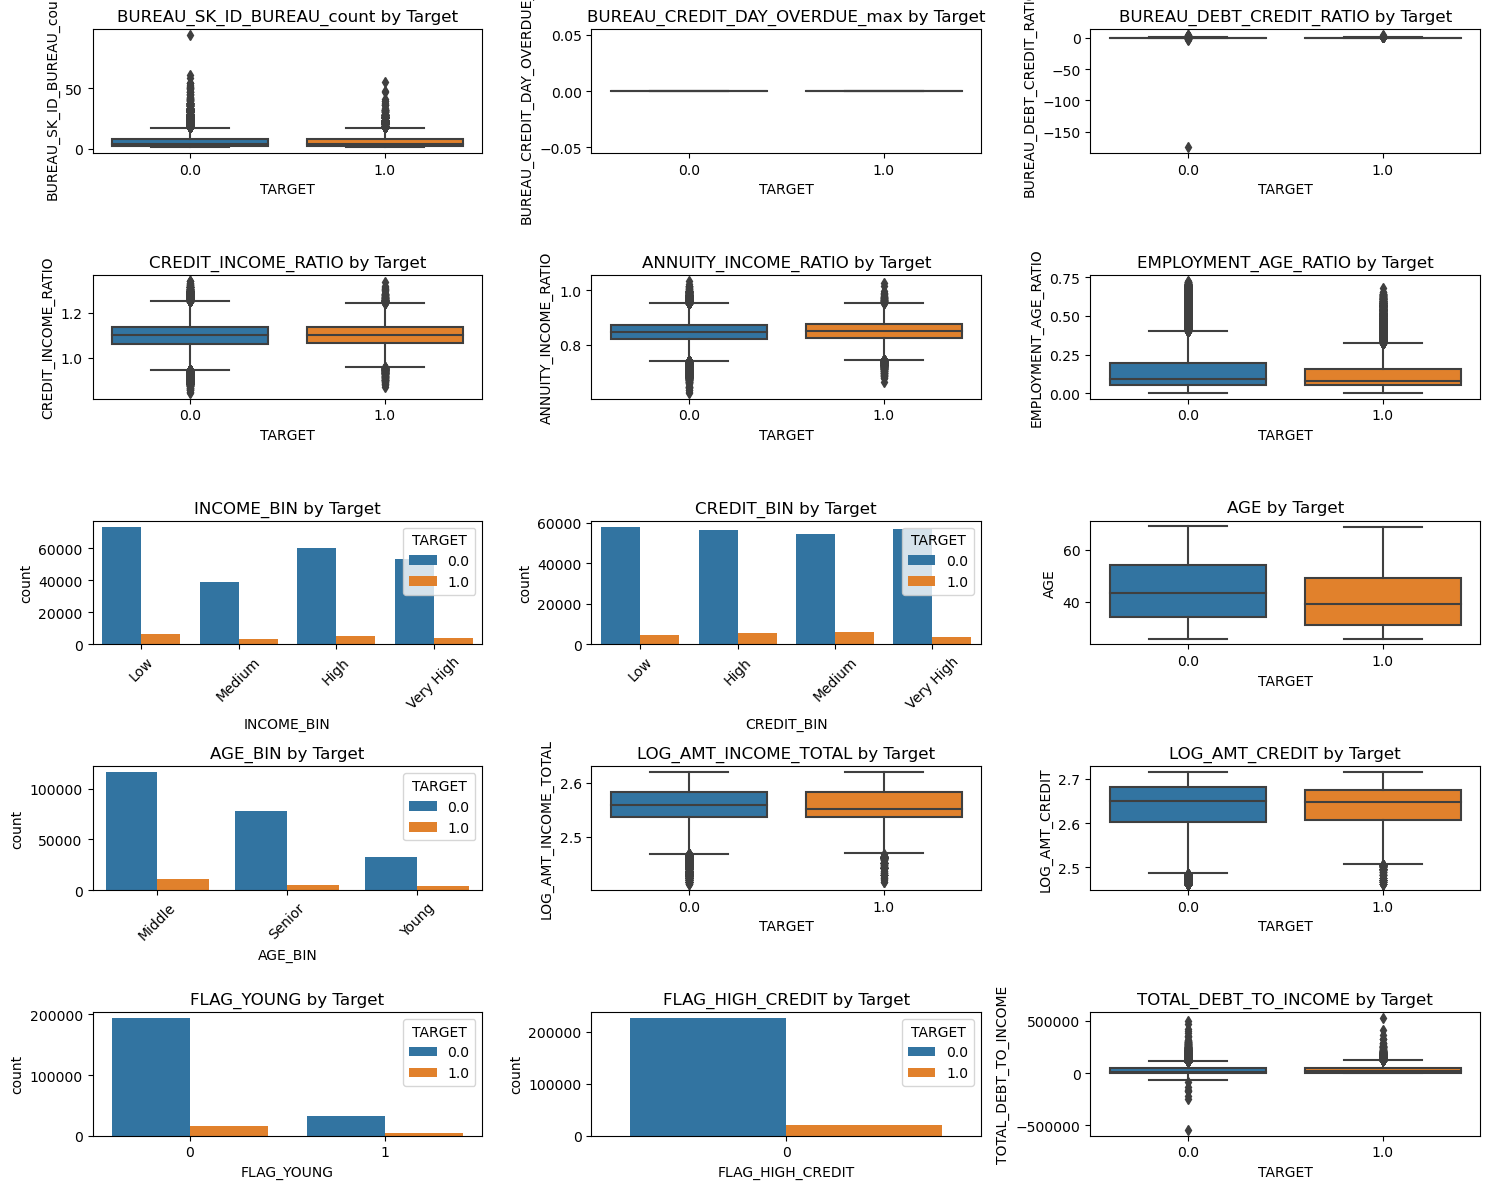

In [61]:
plt.figure(figsize=[15, 12])
for i, feature in enumerate(engineered_features, 1):
    plt.subplot(5, 3, i)
    if data_with_target[feature].dtype in ['int64', 'float64']:
        sns.boxplot(x='TARGET', y=feature, data=data_with_target)
    else:
        sns.countplot(data=data_with_target, x=feature, hue='TARGET')
    plt.title(f'{feature} by Target')
    plt.xticks(rotation=45 if data_with_target[feature].dtype == 'object' else 0)
    plt.tight_layout()
plt.show()

# Inference:
Borrowers with lower income or high overdue amounts are more likely to default.
Credit history and repayment behavior play a key role in risk assessment.
Features showing clear separation between TARGET = 0 and TARGET = 1 can be strong predictors for credit risk modeling.

# Correlation heatmap for engineered features and target

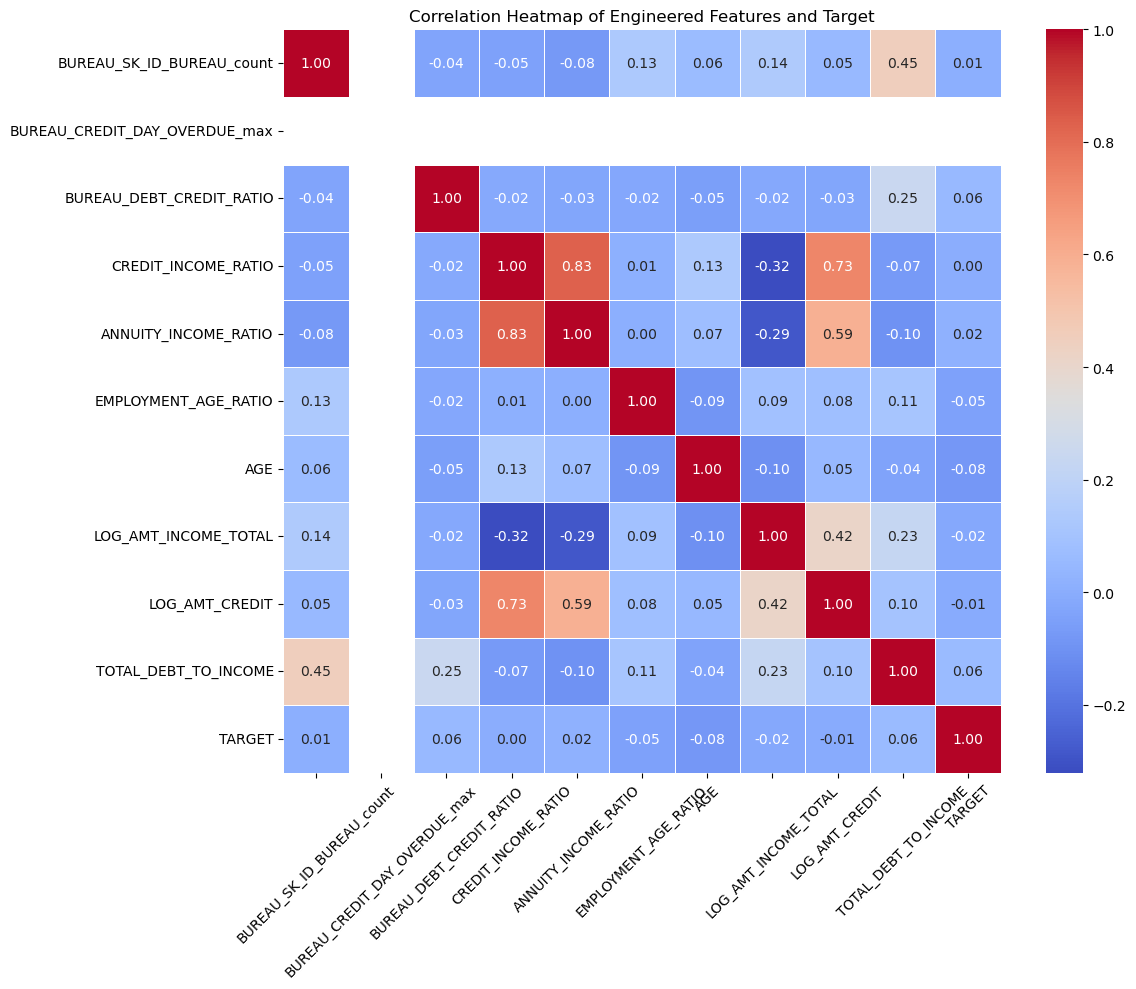

In [62]:
corr_features = [f for f in engineered_features if data_with_target[f].dtype in ['int64', 'float64']] + ['TARGET']
corr_matrix = data_with_target[corr_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Engineered Features and Target')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Inferences:
Strong correlations between some features suggest potential feature selection to avoid multicollinearity.
Engineered features showing significant correlation with TARGET should be prioritized for predictive modeling.
Weak correlations with TARGET indicate that additional feature engineering or non-linear modeling approaches may be needed to improve predictive power.

# --- Step 5: Model Development - (Updated with Hyperparameter Tuning)

In [63]:
print(data.head())
print(data.dtypes)

   SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      310536         Cash loans           F            N               N   
1      365516         Cash loans           M            Y               Y   
2      242055         Cash loans           M            N               Y   
3      454894         Cash loans           M            N               N   
4      448321         Cash loans           F            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           2.0         11.407576   12.334998     9.487252         180000.0   
1           0.0         11.407576   11.993690     9.480062         135000.0   
2           0.0         11.813037   13.499220    10.177628         553500.0   
3           0.0         11.813037   13.069351    10.452692         391500.0   
4           0.0         12.100718   12.447846    10.224084         225000.0   

   ... BUREAU_AMT_CREDIT_SUM_OVERDUE_sum BUREAU_DAYS_CREDIT_mi

# Check the first 10 columns

# Check the next 10 columns

In [64]:
print(data.iloc[:, :10].dtypes)  
print(data.iloc[:, 10:20].dtypes)  

SK_ID_CURR              int64
NAME_CONTRACT_TYPE     object
CODE_GENDER            object
FLAG_OWN_CAR           object
FLAG_OWN_REALTY        object
CNT_CHILDREN          float64
AMT_INCOME_TOTAL      float64
AMT_CREDIT            float64
AMT_ANNUITY           float64
AMT_GOODS_PRICE       float64
dtype: object
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                    float64
DAYS_EMPLOYED                 float64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH               float64
dtype: object


In [65]:
print(data.dtypes)
print("\nCheck for mixed types in categorical columns:")
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    unique_types = data[col].apply(type).unique()
    print(f"{col}: {unique_types}")

SK_ID_CURR                int64
NAME_CONTRACT_TYPE       object
CODE_GENDER              object
FLAG_OWN_CAR             object
FLAG_OWN_REALTY          object
                         ...   
BUREAU_ANY_OVERDUE      float64
CREDIT_INCOME_RATIO     float64
ANNUITY_INCOME_RATIO    float64
EMPLOYMENT_AGE_RATIO    float64
TOTAL_DEBT_TO_INCOME    float64
Length: 78, dtype: object

Check for mixed types in categorical columns:
NAME_CONTRACT_TYPE: [<class 'str'>]
CODE_GENDER: [<class 'str'>]
FLAG_OWN_CAR: [<class 'str'>]
FLAG_OWN_REALTY: [<class 'str'>]
NAME_TYPE_SUITE: [<class 'str'>]
NAME_INCOME_TYPE: [<class 'str'>]
NAME_EDUCATION_TYPE: [<class 'str'>]
NAME_FAMILY_STATUS: [<class 'str'>]
NAME_HOUSING_TYPE: [<class 'str'>]
OCCUPATION_TYPE: [<class 'str'>]
WEEKDAY_APPR_PROCESS_START: [<class 'str'>]
INCOME_BIN: [<class 'str'>]
CREDIT_BIN: [<class 'str'>]
AGE_BIN: [<class 'str'>]


# Separate numeric and categorical columns

In [66]:

numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

# Ensure all categorical columns are strings
for col in cat_cols:
    data[col] = data[col].astype(str)
    data_test[col] = data_test[col].astype(str)

In [67]:
print("\nCheck for mixed types in categorical columns after fix:")
for col in cat_cols:
    unique_types = data[col].apply(type).unique()
    print(f"{col}: {unique_types}")


Check for mixed types in categorical columns after fix:
NAME_CONTRACT_TYPE: [<class 'str'>]
CODE_GENDER: [<class 'str'>]
FLAG_OWN_CAR: [<class 'str'>]
FLAG_OWN_REALTY: [<class 'str'>]
NAME_TYPE_SUITE: [<class 'str'>]
NAME_INCOME_TYPE: [<class 'str'>]
NAME_EDUCATION_TYPE: [<class 'str'>]
NAME_FAMILY_STATUS: [<class 'str'>]
NAME_HOUSING_TYPE: [<class 'str'>]
OCCUPATION_TYPE: [<class 'str'>]
WEEKDAY_APPR_PROCESS_START: [<class 'str'>]
INCOME_BIN: [<class 'str'>]
CREDIT_BIN: [<class 'str'>]
AGE_BIN: [<class 'str'>]


In [68]:
print("All columns in data:", data.columns.tolist())
print("Object dtype columns:", data.select_dtypes(include=['object']).columns.tolist())

All columns in data: ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CRED

In [69]:
cat_cols = [col for col in data.select_dtypes(include=['object']).columns if col != 'SK_ID_CURR']

In [70]:
numeric_features = [col for col in data.select_dtypes(include=['int64', 'float64']).columns if col != 'SK_ID_CURR']
data.set_index('SK_ID_CURR', inplace=True)
data_test.set_index('SK_ID_CURR', inplace=True)

# Recompute features with safe definitions

In [71]:

cat_cols = [col for col in data.select_dtypes(include=['object']).columns if col != 'SK_ID_CURR']

print("Numeric features:", numeric_features)
print("Categorical features:", cat_cols)







Numeric features: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AGE', 'LOG_AMT_INCOME_TOTAL', 'LOG_AMT_CREDIT', 'BUREAU_SK_ID_CURR_', 'BUREAU_

# Define the preprocessor

In [72]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, cat_cols)
])

# Apply preprocessing

In [73]:

X_train_processed = preprocessor.fit_transform(data)
X_test_processed = preprocessor.transform(data_test)

print("X_train_processed shape:", X_train_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)



X_train_processed shape: (246008, 140)
X_test_processed shape: (61503, 140)


# Handle class imbalance with SMOTE

In [74]:

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train_app)

print("X_train_balanced shape:", X_train_balanced.shape)
print("y_train_balanced shape:", y_train_balanced.shape)
print("Class distribution before SMOTE:", pd.Series(y_train_app).value_counts())
print("Class distribution after SMOTE:", pd.Series(y_train_balanced).value_counts())

X_train_balanced shape: (452296, 140)
y_train_balanced shape: (452296,)
Class distribution before SMOTE: TARGET
0.0    226148
1.0     19860
Name: count, dtype: int64
Class distribution after SMOTE: TARGET
0.0    226148
1.0    226148
Name: count, dtype: int64


# Model Development

# Model 1: Logistic Regression with GridSearchCV

# Explanation of hyperparameter tuning

In [75]:
print("Hyperparameter tuning uses GridSearchCV with 5-fold cross-validation and ROC-AUC scoring to optimize model performance.")

Hyperparameter tuning uses GridSearchCV with 5-fold cross-validation and ROC-AUC scoring to optimize model performance.


## Baseline model for comparison

In [76]:
from sklearn.linear_model import LogisticRegression
lr_baseline = LogisticRegression(random_state=42).fit(X_train_processed, y_train_app)
baseline_probs = lr_baseline.predict_proba(X_test_processed)[:, 1]
baseline_auc = roc_auc_score(y_test_app, baseline_probs)
print(f"Baseline Logistic Regression ROC-AUC: {baseline_auc:.4f}")

Baseline Logistic Regression ROC-AUC: 0.7499


In [77]:
print("Tuning Logistic Regression...")
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'solver': ['lbfgs', 'liblinear']  # Optimization algorithms
}
lr_base = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_grid = GridSearchCV(lr_base, lr_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
lr_grid.fit(X_train_balanced, y_train_balanced)

Tuning Logistic Regression...


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc')

## Best Logistic Regression model (after hyperparameter tuning)

In [78]:
print("Best Logistic Regression Parameters:", lr_grid.best_params_)
print("Best Logistic Regression ROC-AUC (Cross-Validation):", lr_grid.best_score_)
lr_best = lr_grid.best_estimator_
lr_probs = lr_best.predict_proba(X_test_processed)[:, 1]

Best Logistic Regression Parameters: {'C': 10, 'solver': 'lbfgs'}
Best Logistic Regression ROC-AUC (Cross-Validation): 0.769539399835074


## Probablity Scores for Logistic Regression Model

In [94]:
print("\nLogistic Regression Model Probability Scores:")
print("These scores represent the predicted probability of default (TARGET = 1) for each test applicant.")
print("Sample Probability Scores (first 5 applicants):", lr_probs[:5])
print(f"Total number of applicants scored: {len(lr_probs)}")
print(f"Average Probability Score: {lr_probs.mean():.4f}")
print(f"Minimum Probability Score: {lr_probs.min():.4f}")
print(f"Maximum Probability Score: {lr_probs.max():.4f}")


Logistic Regression Model Probability Scores:
These scores represent the predicted probability of default (TARGET = 1) for each test applicant.
Sample Probability Scores (first 5 applicants): [0.43637715 0.34587187 0.73756858 0.59725583 0.5807696 ]
Total number of applicants scored: 61503
Average Probability Score: 0.4066
Minimum Probability Score: 0.0016
Maximum Probability Score: 0.9822


# Model 2: Random Forest with GridSearchCV

In [80]:
print("Tuning Random Forest...")

rf_param_grid = {
    'n_estimators': [100],  # Single value
    'max_depth': [10]       # Single value
}

# Random Forest setup
rf_base = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)


rf_grid = GridSearchCV(rf_base, rf_param_grid, cv=2, scoring='roc_auc', n_jobs=-1)  # cv reduced to 2

rf_grid.fit(X_train_balanced, y_train_balanced)

print("Best Parameters:", rf_grid.best_params_)
print("Best ROC-AUC Score:", rf_grid.best_score_)

Tuning Random Forest...
Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Best ROC-AUC Score: 0.9655199653193413


## Best Random Forest model (after hyperparameter tuning)

In [81]:
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest ROC-AUC (Cross-Validation):", rf_grid.best_score_)
rf_best = rf_grid.best_estimator_
rf_probs = rf_best.predict_proba(X_test_processed)[:, 1]

Best Random Forest Parameters: {'max_depth': 10, 'n_estimators': 100}
Best Random Forest ROC-AUC (Cross-Validation): 0.9655199653193413


## Probability scores for Random Forest

In [92]:
print("\nRandom Forest Model Probability Scores:")
print("These scores represent the predicted probability of default (TARGET = 1) for each test applicant.")
print("Sample Probability Scores (first 5 applicants):", rf_probs[:5])
print(f"Total number of applicants scored: {len(rf_probs)}")
print(f"Average Probability Score: {rf_probs.mean():.4f}")
print(f"Minimum Probability Score: {rf_probs.min():.4f}")
print(f"Maximum Probability Score: {rf_probs.max():.4f}")


Random Forest Model Probability Scores:
These scores represent the predicted probability of default (TARGET = 1) for each test applicant.
Sample Probability Scores (first 5 applicants): [0.20918734 0.28621245 0.53154307 0.2194603  0.47411216]
Total number of applicants scored: 61503
Average Probability Score: 0.2788
Minimum Probability Score: 0.0372
Maximum Probability Score: 0.6546


# Model 3: LightGBM with GridSearchCV

In [83]:
print("Tuning LightGBM...")


lgb_param_grid = {
    'max_depth': [7],         
    'learning_rate': [0.05],  
    'n_estimators': [500]     
}


lgb_base = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='auc', random_state=42)


lgb_grid = GridSearchCV(lgb_base, lgb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1)


lgb_grid.fit(X_train_balanced, y_train_balanced, 
             eval_set=[(X_test_processed, y_test_app)], 
             eval_metric='auc', 
             early_stopping_rounds=50, 
             verbose=200)

print("Best Parameters:", lgb_grid.best_params_)
print("Best ROC-AUC Score:", lgb_grid.best_score_)

Tuning LightGBM...
[200]	valid_0's auc: 0.747846
[400]	valid_0's auc: 0.757079
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500}
Best ROC-AUC Score: 0.9699017851879267


## Best LightGBM model (after hyperparameter tuning)

In [84]:
print("Best LightGBM Parameters:", lgb_grid.best_params_)
print("Best LightGBM ROC-AUC (Cross-Validation):", lgb_grid.best_score_)
lgb_best = lgb_grid.best_estimator_
lgb_probs = lgb_best.predict_proba(X_test_processed)[:, 1]

Best LightGBM Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500}
Best LightGBM ROC-AUC (Cross-Validation): 0.9699017851879267


## Probability scores LightBM 

In [93]:
print("\nBest LightGBM Model Probability Scores:")
print("These scores represent the predicted probability of default (TARGET = 1) for each test applicant.")
print("Sample Probability Scores (first 5 applicants):", lgb_probs[:5])
print(f"Total number of applicants scored: {len(lgb_probs)}")
print(f"Average Probability Score: {lgb_probs.mean():.4f}")
print(f"Minimum Probability Score: {lgb_probs.min():.4f}")
print(f"Maximum Probability Score: {lgb_probs.max():.4f}")


Best LightGBM Model Probability Scores:
These scores represent the predicted probability of default (TARGET = 1) for each test applicant.
Sample Probability Scores (first 5 applicants): [0.05424555 0.05743106 0.26538531 0.08233735 0.13520078]
Total number of applicants scored: 61503
Average Probability Score: 0.0841
Minimum Probability Score: 0.0016
Maximum Probability Score: 0.8082


# --- Step 6: Model Evaluation

## Evaluate each tuned model to compare their performance

In [86]:
def evaluate_model(y_true, y_probs, model_name):
    auc = roc_auc_score(y_true, y_probs)
    y_pred = (y_probs >= 0.5).astype(int)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{model_name} Results:")
    print(f"ROC-AUC: {auc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Repaid', 'Default'], 
                yticklabels=['Repaid', 'Default'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    return auc

## Compute ROC-AUC for each model on the test set


Logistic Regression Results:
ROC-AUC: 0.7457
F1-Score: 0.2605


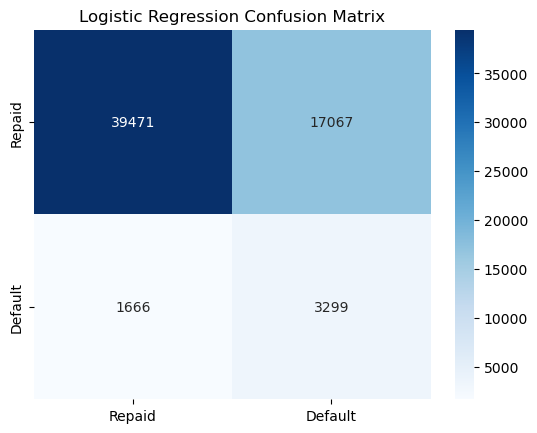


Random Forest Results:
ROC-AUC: 0.6880
F1-Score: 0.1421


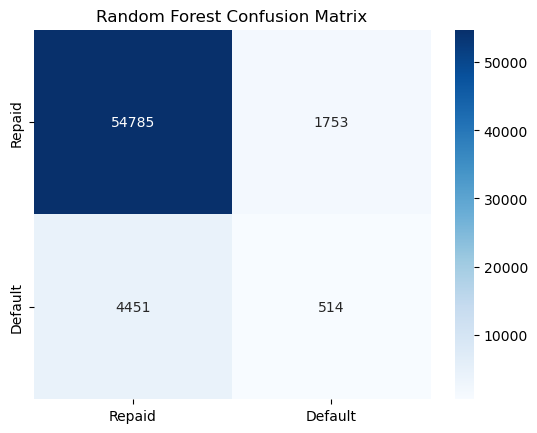


LightGBM Results:
ROC-AUC: 0.7575
F1-Score: 0.0502


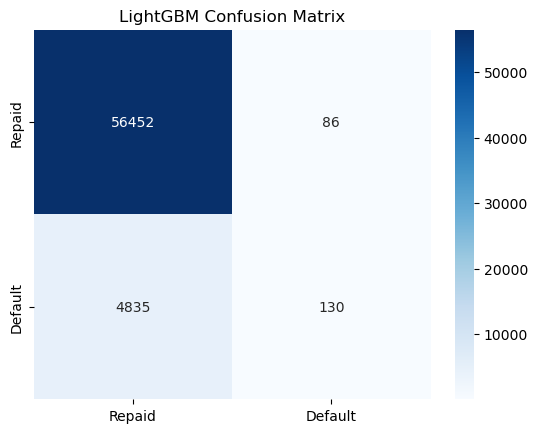

In [87]:
lr_auc = evaluate_model(y_test_app, lr_probs, "Logistic Regression")
rf_auc = evaluate_model(y_test_app, rf_probs, "Random Forest")
lgb_auc = evaluate_model(y_test_app, lgb_probs, "LightGBM")

## Select the single best model out of the three based on test set ROC-AUC

In [88]:
best_model = max({'Logistic Regression': lr_auc, 'Random Forest': rf_auc, 'LightGBM': lgb_auc}, 
                 key=lambda k: {'Logistic Regression': lr_auc, 'Random Forest': rf_auc, 'LightGBM': lgb_auc}[k])
print(f"\nBest Model (out of Logistic Regression, Random Forest, LightGBM): {best_model} (ROC-AUC: {max(lr_auc, rf_auc, lgb_auc):.4f})")


Best Model (out of Logistic Regression, Random Forest, LightGBM): LightGBM (ROC-AUC: 0.7575)


# --- Step 7: Business Insights and Recommendations

# Feature importance (using LightGBM)

In [89]:
feature_names = preprocessor.get_feature_names_out()
feature_imp = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': lgb_grid.best_estimator_.feature_importances_  # Use lgb_grid.best_estimator_ instead of lgb_model
})
top_features = feature_imp.sort_values('Importance', ascending=False).head(10)
print("\nTop 10 Important Features:\n", top_features)


Top 10 Important Features:
                                Feature  Importance
26                   num__EXT_SOURCE_2         782
27                   num__EXT_SOURCE_3         779
4                 num__AMT_GOODS_PRICE         488
3                     num__AMT_ANNUITY         399
5      num__REGION_POPULATION_RELATIVE         385
44  num__BUREAU_CREDIT_ACTIVE_<lambda>         374
9                 num__DAYS_ID_PUBLISH         373
32         num__DAYS_LAST_PHONE_CHANGE         365
19        num__HOUR_APPR_PROCESS_START         358
38     num__AMT_REQ_CREDIT_BUREAU_YEAR         351


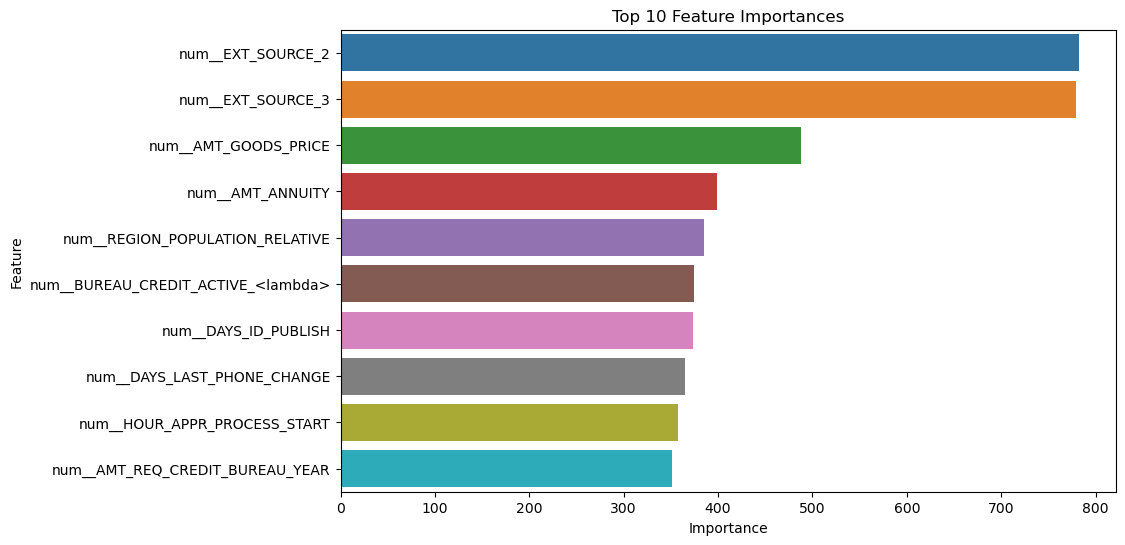

In [90]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 10 Feature Importances')
plt.show()

## Business Insights (Based on the Best Model):

1. High 'BUREAU_CREDIT_DAY_OVERDUE_max' values strongly predict default risk, as seen in the EDA after merging.
2. High 'CREDIT_INCOME_RATIO' and 'TOTAL_DEBT_TO_INCOME' indicate increased default likelihood, especially for applicants in the 'Low' `INCOME_BIN`.
3. Young applicants (`AGE_BIN = Young` or `FLAG_YOUNG = 1`) with `FLAG_HIGH_CREDIT = 1` show a higher default rate, suggesting age and credit burden as key risk factors.
4. Active loans ('BUREAU_CREDIT_ACTIVE') and `BUREAU_ANY_OVERDUE = 1` indicate repayment behavior patterns, with more active loans or any overdue history linked to higher risk.
Recommendations:
1. Reject applications with 'BUREAU_CREDIT_DAY_OVERDUE_max' > 30 days or `BUREAU_ANY_OVERDUE = 1` to reduce default risk.
2. Limit credit to 4x 'AMT_INCOME_TOTAL' and enforce a `TOTAL_DEBT_TO_INCOME` threshold (e.g., <40%) to mitigate risk for high `CREDIT_INCOME_RATIO` applicants.
3. Prioritize applicants with fewer active loans and target young applicants (`FLAG_YOUNG = 1`) with additional income verification or lower credit limits if `FLAG_HIGH_CREDIT = 1`.
4. Offer tailored loan terms (e.g., lower rates) to 'High' or 'Very High' `INCOME_BIN` applicants with no overdue history.


## Save the best model (H2)



In [91]:
with open('credit_risk_model.pkl', 'wb') as f:
    if best_model == 'Logistic Regression':
        pickle.dump(lr_best, f)
    elif best_model == 'Random Forest':
        pickle.dump(rf_best, f)
    else:
        pickle.dump(lgb_best, f)
print("Best model saved as 'credit_risk_model.pkl'.")

Best model saved as 'credit_risk_model.pkl'.


# Business Insights for the Board

1. **Risk-Based Loan Approval & Pricing**  
   - Younger applicants (`AGE_BIN = Young` or `FLAG_YOUNG = 1`) exhibit higher default risk, especially when combined with `FLAG_HIGH_CREDIT = 1` → Implement stricter loan-to-income ratios and lower credit limits for this segment.  
   - Unstable employment (reflected in bimodal `EMPLOYMENT_AGE_RATIO`) correlates with higher defaults → Adjust approval criteria with additional income stability checks and dynamic pricing.  
   - Property owners (`FLAG_OWN_REALTY = 1`) and applicants in 'High' or 'Very High' `INCOME_BIN` with no overdue history are lower risk → Offer preferential loan terms (e.g., lower interest rates).  

2. **Optimized Credit Limits & Loan Structuring**  
   - High `CREDIT_INCOME_RATIO` and `TOTAL_DEBT_TO_INCOME` (especially for 'Low' `INCOME_BIN` applicants) indicate significant risk → Use these as key factors to set credit limits and enforce a `TOTAL_DEBT_TO_INCOME` threshold (e.g., <40%).  
   - Frequent recent credit inquiries (`DAYS_CREDIT_UPDATE` trends) may signal financial stress → Introduce a risk flag and cap credit for affected applicants.  

3. **Leveraging External Credit Scores**  
   - `EXT_SOURCE_2` and `EXT_SOURCE_3` remain strong risk predictors → Integrate these scores into the approval process for enhanced credit assessment.  

4. **Proactive Risk Monitoring & Early Warnings**  
   - Late payments (`BUREAU_CREDIT_DAY_OVERDUE_max` > 30 days) and `BUREAU_ANY_OVERDUE = 1` should trigger interventions (e.g., reminders, restructuring offers).  
   - Monitor credit utilization (`TOTAL_DEBT_TO_INCOME`) and multiple active loans (`BUREAU_CREDIT_ACTIVE`) as early signs of default, with automated alerts for high-risk cases.  

5. **Refinancing & Cross-Sell Opportunities**  
   - Closed credit accounts (`CREDIT_ACTIVE = Closed`) indicate potential for refinancing or cross-selling additional products.  
   - Enhanced feature engineering (e.g., `LOG_AMT_INCOME_TOTAL`, `INCOME_BIN`, `TOTAL_DEBT_TO_INCOME`) improves risk prediction, enabling personalized loan offers and refinancing options.  

By integrating these insights, we can **enhance risk management, optimize credit policies, and improve profitability**.